# KL Divergence Test

## General

### Imports

In [1]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext
from scipy.stats import multivariate_normal
import math

import ToyExample.dnnlib.util as dnnlib
from ToyExample.torch_utils import persistence
import ToyExample.training.phema as phema

import ToyExample.toy_example as toy

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
sigma_min=0.002
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda:0')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

### Initialization

In [3]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [4]:
# Initialize models
gtd = toy.gt(classes, device)[0]
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded")
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

Guide model loaded


## Discrete KL divergence

### My implementation
<font color="darkorange"><font size=2>_Wrong because I'm not sampling from pure Gaussian noise_</font></font>

In [5]:
def estimate_KL_divergence(model, n_samples, logging=False):
    sigma = (torch.randn(n_samples, device=device) * P_std + P_mean).exp()
    samples = toy.gt(classes, device).sample(n_samples, sigma) #Q: Why do they redefine the Gaussian mixture distribution twice on each iteration?
    gt_logp = toy.gt(classes, device).logp(samples, sigma)
    net_logp = model.logp(samples, sigma)
    if logging:
        print("Samples", samples[:10])
        print("Ground Truth Logp", gt_logp[:10])
        print("Model's Logp", net_logp[:10])
        print("Model's Max Logp", max(net_logp[:10]))
        print("Model's Min Logp", min(net_logp[:10]))
        print("Model's p", torch.exp( net_logp )[:10])
    return float(torch.sum( torch.exp( net_logp - max(net_logp) ) * (net_logp - gt_logp) ) / n_samples)

In [30]:
batch_size = 1<<18 # 1<<18 takes a full second
estimate_KL_divergence(guide, batch_size)

Samples tensor([[ 0.3750,  1.2422],
        [-0.0401,  0.0893],
        [ 2.1985,  1.0319],
        [ 0.1186,  0.0788],
        [ 0.4186,  0.4665],
        [ 0.1633,  0.5172],
        [ 0.1835,  0.2117],
        [ 0.5415,  0.6946],
        [ 0.0161,  0.5386],
        [ 0.8778, -0.0187]], device='cuda:0')
Ground Truth Logp tensor([-1.9154, -0.5419, -3.9375, -1.9402, -0.2401,  0.5995,  1.3995, -0.9313,
        -0.3543, -0.6567], device='cuda:0')
Model's Logp tensor([ 3.6239,  7.9367,  0.4473,  2.0451, 14.0206, 35.8806, 31.6398,  8.9845,
        19.9973, 31.2320], device='cuda:0')
Model's Max Logp tensor(35.8806, device='cuda:0')
Model's Min Logp tensor(0.4473, device='cuda:0')
Model's p tensor([3.7485e+01, 2.7982e+03, 1.5640e+00, 7.7302e+00, 1.2276e+06, 3.8260e+15,
        5.5081e+13, 7.9788e+03, 4.8386e+08, 3.6635e+13], device='cuda:0')


0.02727900817990303

#### Check for guide and for untrained model

In [ ]:
n_samples = [1<<i for i in range(13,19)]

net_mean_results, net_std_results = [], []
guide_mean_results, guide_std_results = [], []
for n in n_samples:
    net_results, guide_results = [], []
    for k in range(10): 
        net_results.append( estimate_KL_divergence(net, n) )
        guide_results.append( estimate_KL_divergence(guide, n) )
    net_mean_results.append( float(np.mean( net_results )) )
    net_std_results.append( float(np.std( net_results )) )
    guide_mean_results.append( float(np.mean( guide_results )) )
    guide_std_results.append( float(np.std( guide_results )) )


In [34]:
net_mean_results

[-0.15338555425405503,
 -0.15949326604604722,
 -0.15788108110427856,
 -0.15793289244174957,
 -0.15666548907756805,
 -0.15716473758220673]

In [35]:
net_std_results

[0.006897717240097406,
 0.006643645146808534,
 0.006324348566740532,
 0.001403445788673892,
 0.0017624047203736685,
 0.0020937785389164294]

In [36]:
guide_mean_results

[0.41950732171535493,
 0.2291453957557678,
 0.1409598931670189,
 0.10249877572059632,
 0.05564229823648929,
 0.03509714342653751]

In [37]:
guide_std_results

[0.1693544528145813,
 0.07284975098757966,
 0.053083673239432735,
 0.055096763107228844,
 0.015086107040142663,
 0.00745716254367764]

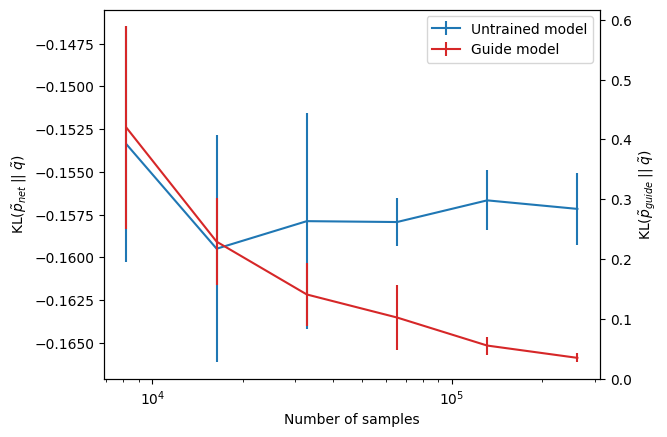

In [53]:
fig, axes = plt.subplots()
axes = [axes, axes.twinx()]
l0 = axes[0].errorbar(n_samples, net_mean_results, net_std_results, 
                      color="C0", label="Untrained model")
l1 = axes[1].errorbar(n_samples, guide_mean_results, guide_std_results, 
                      color="C3", label="Guide")
for ax in axes: ax.set_xscale("log")
axes[0].set_ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
axes[1].set_ylabel(r"KL$(\tilde{p}_{guide}\;||\;\tilde{q})$");
axes[0].set_xlabel("Number of samples");
plt.legend([l0, l1], ["Untrained model", "Guide model"])

#### Check for all different checkpoints in a training run

In [9]:
n_samples = 1<<17
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", 
                                "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [ ]:
mean_results, std_results = [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    results = []
    
    # Estimate 10 times
    for k in range(10): 
        results.append( estimate_KL_divergence(model, n_samples) )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( results )) )
    std_results.append( float(np.std( results )) )

# 16 checkpoints took 7 min ==> 27 sec per checkpoint, quite expensive

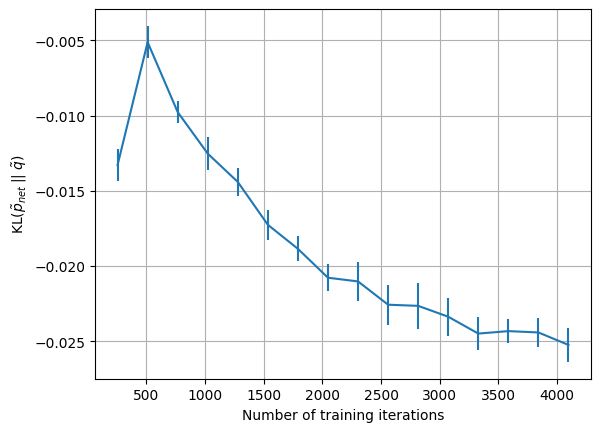

In [14]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0")
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

### Torch implementation
<font color="darkorange"><font size=2>_Wrong because I'm not sampling from pure Gaussian noise_</font></font>

In [ ]:
# Define the KL divergence function
torch_KL_divergence = torch.nn.KLDivLoss(log_target=True, reduction="batchmean") 
# Assume both inputs are probabilities in log-space

# Ground truth distribution
gtd = toy.gt(classes, device)[0]

def estimate_torch_KL_divergence(model, n_samples):

    # Sample ground truth from random intermediate time steps
    sigma = (torch.randn(n_samples, device=device) * P_std + P_mean).exp()
    samples = gtd.sample(n_samples, sigma)
    gt_logp = gtd.logp(samples, sigma)
    net_logp = model.logp(samples, sigma)

    return float( torch_KL_divergence(net_logp, gt_logp) )

In [11]:
sigma_max = 5
n_samples = 1<<16 # 1<<18 takes a full second

print( estimate_torch_KL_divergence(net, n_samples) )

2.7738945484161377


#### Check for guide and for untrained model

In [7]:
n_samples = [1<<i for i in range(13,19)]

net_mean_results, net_std_results = [], []
guide_mean_results, guide_std_results = [], []
for n in n_samples:
    net_results, guide_results = [], []
    for k in range(10): 
        net_results.append( estimate_torch_KL_divergence(net, n) )
        guide_results.append( estimate_torch_KL_divergence(guide, n) )
    net_mean_results.append( float(np.mean( net_results )) )
    net_std_results.append( float(np.std( net_results )) )
    guide_mean_results.append( float(np.mean( guide_results )) )
    guide_std_results.append( float(np.std( guide_results )) )


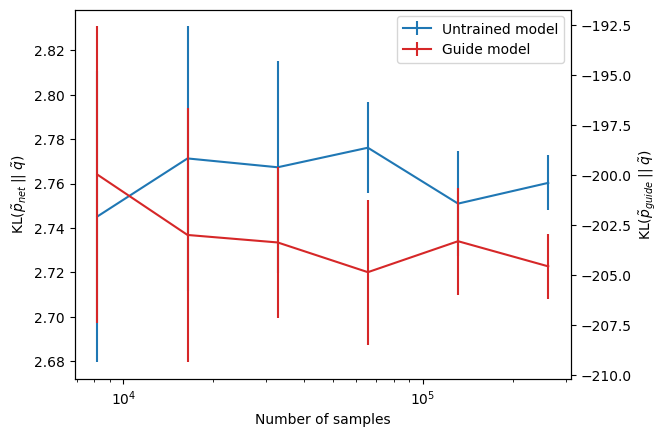

In [8]:
fig, axes = plt.subplots()
axes = [axes, axes.twinx()]
l0 = axes[0].errorbar(n_samples, net_mean_results, net_std_results, 
                      color="C0", label="Untrained model")
l1 = axes[1].errorbar(n_samples, guide_mean_results, guide_std_results, 
                      color="C3", label="Guide")
for ax in axes: ax.set_xscale("log")
axes[0].set_ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
axes[1].set_ylabel(r"KL$(\tilde{p}_{guide}\;||\;\tilde{q})$");
axes[0].set_xlabel("Number of samples");
plt.legend([l0, l1], ["Untrained model", "Guide model"])

#### Check for all different checkpoints in a training run

In [24]:
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints.sort()
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [30]:
n_samples = 1<<16

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_torch_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

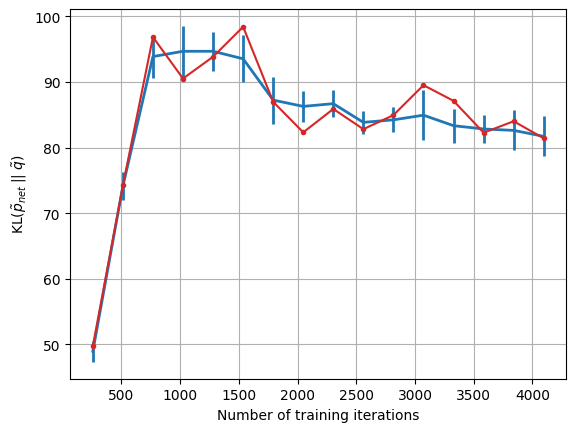

In [39]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

In [40]:
n_samples = 1<<17

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_torch_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

In [52]:
(1*60+16)/len(checkpoints_filepaths)/10

0.475

In [ ]:
60*(60+20)/4096

1.171875

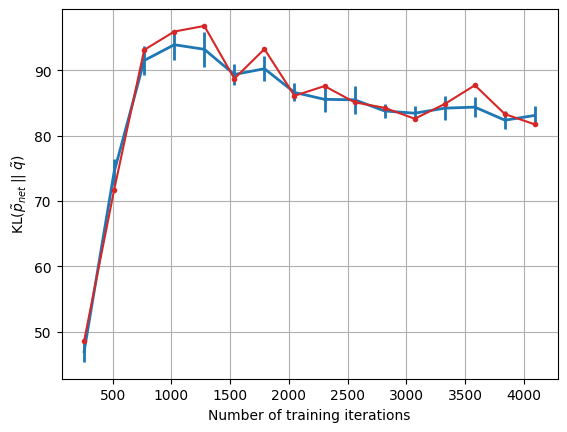

In [41]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

In [42]:
n_samples = 1<<18

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_torch_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

In [51]:
(2*60+30)/len(checkpoints_filepaths)/10

0.9375

In [ ]:
60*(60+20)/4096

1.171875

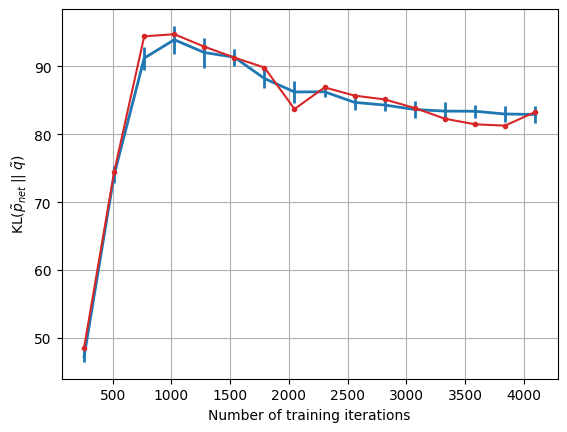

In [43]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

### Torch implementation from Gaussian noise
<font color="darkorange"><font size=2>_Wrong due to negative results, probably lack of normalization_</font></font>  $\rightarrow$ See this [issue](https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/6)

In [ ]:
# Define the KL divergence function
torch_KL_divergence = torch.nn.KLDivLoss(log_target=True, reduction="batchmean") 
# Assume both inputs are probabilities in log-space

# Ground truth distribution
gtd = toy.gt(classes, device)[0]

def estimate_torch_KL_divergence(model, n_samples):

    # Sample ground truth from pure Gaussian noise
    samples = gtd.sample(n_samples, sigma_max)
    gt_logp = gtd.logp(samples, sigma_max)
    net_logp = model.logp(samples, sigma_max)

    return float( torch_KL_divergence(net_logp, gt_logp) )

In [13]:
sigma_max = 5
n_samples = 1<<16 # 1<<18 takes a full second

print( estimate_torch_KL_divergence(net, n_samples) )

-0.015994546934962273


#### Check for guide and for untrained model

In [14]:
n_samples = [1<<i for i in range(13,19)]

net_mean_results, net_std_results = [], []
guide_mean_results, guide_std_results = [], []
for n in n_samples:
    net_results, guide_results = [], []
    for k in range(10): 
        net_results.append( estimate_torch_KL_divergence(net, n) )
        guide_results.append( estimate_torch_KL_divergence(guide, n) )
    net_mean_results.append( float(np.mean( net_results )) )
    net_std_results.append( float(np.std( net_results )) )
    guide_mean_results.append( float(np.mean( guide_results )) )
    guide_std_results.append( float(np.std( guide_results )) )


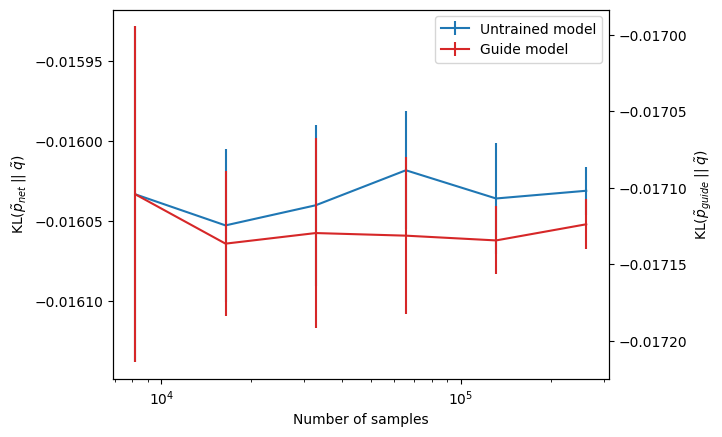

In [15]:
fig, axes = plt.subplots()
axes = [axes, axes.twinx()]
l0 = axes[0].errorbar(n_samples, net_mean_results, net_std_results, 
                      color="C0", label="Untrained model")
l1 = axes[1].errorbar(n_samples, guide_mean_results, guide_std_results, 
                      color="C3", label="Guide")
for ax in axes: ax.set_xscale("log")
axes[0].set_ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
axes[1].set_ylabel(r"KL$(\tilde{p}_{guide}\;||\;\tilde{q})$");
axes[0].set_xlabel("Number of samples");
plt.legend([l0, l1], ["Untrained model", "Guide model"])

#### Check for all different checkpoints in a training run

In [16]:
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints.sort()
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [19]:
n_samples = 1<<18

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_torch_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

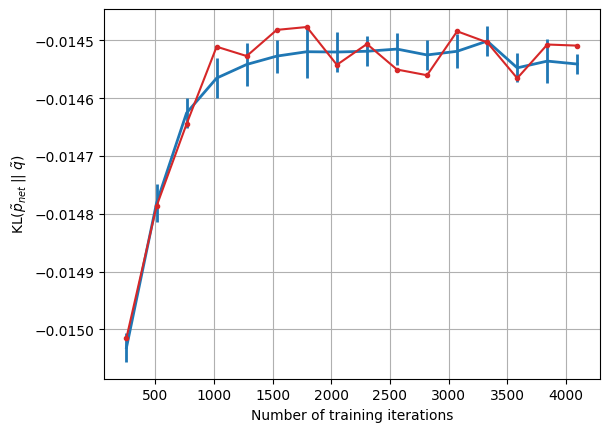

In [18]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

### My implementation, sampling from Gaussian noise

<font color="lime"><font size=2>Why do the values go up close to the end of the training run?</font></font>

In [ ]:
def estimate_KL_divergence(model, n_samples, logging=False):
    gtd = toy.gt(classes, device)[0]
    samples = gtd.sample(n_samples, sigma_max)
    gt_logp = gtd.logp(samples, sigma_max)
    net_logp = model.logp(samples, sigma_max)
    if logging:
        print("Samples", samples[:10])
        print("Ground Truth Logp", gt_logp[:10])
        print("Model's Logp", net_logp[:10])
        print("Model's Max Logp", max(net_logp[:10]))
        print("Model's Min Logp", min(net_logp[:10]))
        print("Model's p", torch.exp( net_logp )[:10])
    return float(torch.sum( torch.exp( net_logp - torch.max(net_logp) ) * (net_logp - gt_logp) ) / n_samples)

In [57]:
batch_size = 1<<18 # 1<<18 takes a full second
estimate_KL_divergence(guide, batch_size)

2.7677977085113525

#### Check for guide and for untrained model

In [58]:
n_samples = [1<<i for i in range(13,19)]

net_mean_results, net_std_results = [], []
guide_mean_results, guide_std_results = [], []
for n in n_samples:
    net_results, guide_results = [], []
    for k in range(10): 
        net_results.append( estimate_KL_divergence(net, n) )
        guide_results.append( estimate_KL_divergence(guide, n) )
    net_mean_results.append( float(np.mean( net_results )) )
    net_std_results.append( float(np.std( net_results )) )
    guide_mean_results.append( float(np.mean( guide_results )) )
    guide_std_results.append( float(np.std( guide_results )) )


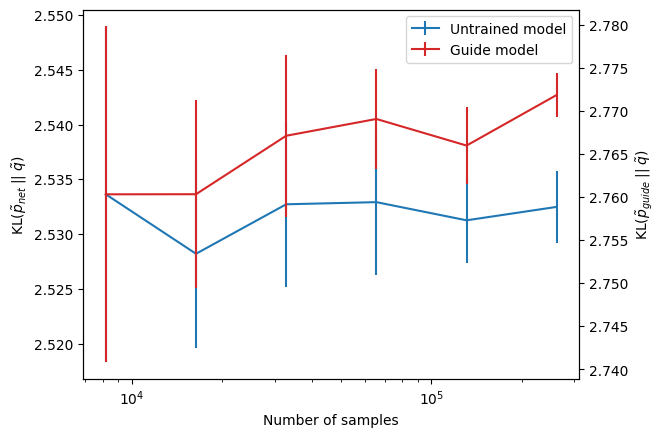

In [59]:
fig, axes = plt.subplots()
axes = [axes, axes.twinx()]
l0 = axes[0].errorbar(n_samples, net_mean_results, net_std_results, 
                      color="C0", label="Untrained model")
l1 = axes[1].errorbar(n_samples, guide_mean_results, guide_std_results, 
                      color="C3", label="Guide")
for ax in axes: ax.set_xscale("log")
axes[0].set_ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
axes[1].set_ylabel(r"KL$(\tilde{p}_{guide}\;||\;\tilde{q})$");
axes[0].set_xlabel("Number of samples");
plt.legend([l0, l1], ["Untrained model", "Guide model"])

#### Check for all different checkpoints in a training run

In [24]:
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints.sort()
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [29]:
n_samples = 1<<16

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

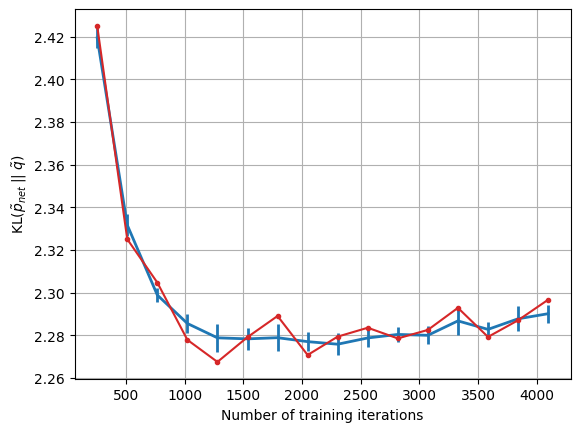

In [30]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

In [31]:
n_samples = 1<<17

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

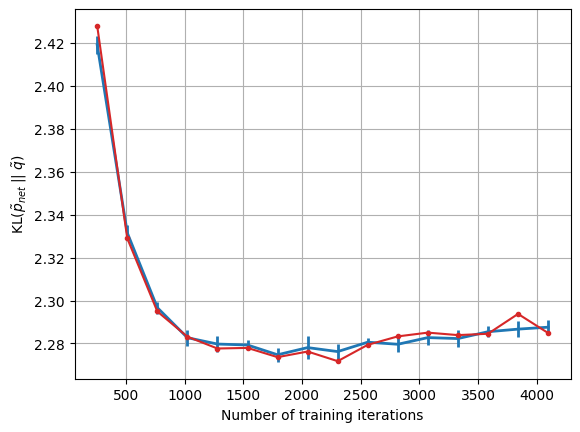

In [32]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

In [27]:
n_samples = 1<<18

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

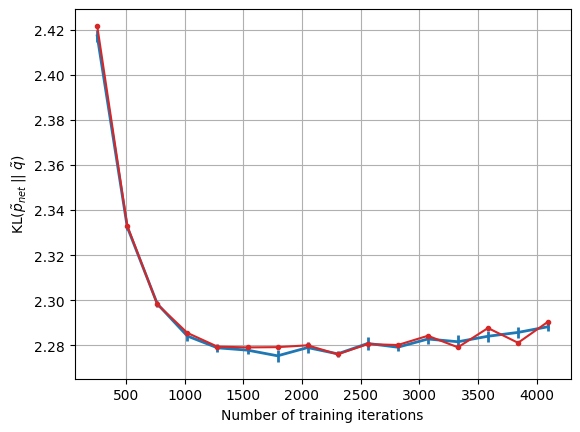

In [28]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

### Torch implementation, normalized

<font color="lime"><font size=2>Why do I get such small values?</font></font>
<font color="lime"><font size=2>What's up with the training curve?</font></font>

In [9]:
# Define the KL divergence function
torch_KL_divergence = torch.nn.KLDivLoss(log_target=True, reduction="batchmean") 
# Assume both inputs are probabilities in log-space

def estimate_torch_KL_divergence(model, n_samples, logging=False):

    # Ground truth distribution
    gtd = toy.gt(classes, device)[0]

    # Sample ground truth from pure Gaussian noise
    samples = gtd.sample(n_samples, sigma_max)
    gt_logp = gtd.logp(samples, sigma_max)
    net_logp = model.logp(samples, sigma_max)

    # Get normalization factor
    gt_normp = torch.sum( torch.exp(gt_logp) )
    # gt_maxlogp = torch.max(gt_logp)
    # gt_normp = torch.sum( torch.exp(gt_logp - gt_maxlogp) ) * torch.exp( gt_maxlogp )
    net_normp = torch.sum( torch.exp(net_logp) )
    # net_maxlogp = torch.max(net_logp)
    # net_normp = torch.sum( torch.exp(net_logp - net_maxlogp) ) * torch.exp( net_maxlogp )

    if logging:
        print("Samples", samples[:10])
        print("Ground Truth Logp", gt_logp[:10])
        print("Model's Logp", net_logp[:10])
        print("Model's Max Logp", max(net_logp))
        print("Model's Min Logp", min(net_logp))
        print("Model's Normalization Factor", net_normp)
        print("Model's p", torch.exp( net_logp )[:10])
        print("Model's Normalized p", torch.exp( net_logp )[:10]/net_normp )
        print("Model's Max Normalized p", torch.max( torch.exp( net_logp - torch.log(net_normp) ) ) )
        print("Model's Normalized p sum", torch.sum( torch.exp( net_logp - torch.log(net_normp) ) ) )
        print("Ground Truth's Normalized p sum", torch.sum( torch.exp( gt_logp - torch.log(gt_normp) ) ) )

    return float( torch_KL_divergence(net_logp - torch.log(net_normp), 
                                      gt_logp - torch.log(gt_normp) ) )

In [11]:
sigma_max = 5
n_samples = 1<<16 # 1<<18 takes a full second

print( estimate_torch_KL_divergence(net, n_samples, logging=True) )

Samples tensor([[  1.4389,   3.1922],
        [ -3.2479,   3.0980],
        [ -6.5175,  -1.1704],
        [  2.3800,  -9.1341],
        [  2.0352,   1.4286],
        [  0.2837,  -2.3742],
        [  0.2912, -11.4794],
        [  1.6533,   1.7856],
        [  5.9481,   2.1611],
        [ -6.9363,  -5.2641]], device='cuda:1')
Ground Truth Logp tensor([-5.2433, -5.4706, -6.0534, -6.9372, -5.1390, -5.2107, -7.8542, -5.1343,
        -5.7450, -6.7565], device='cuda:1')
Model's Logp tensor([-0.2428, -0.3989, -0.8683, -1.7643, -0.1224, -0.1132, -2.6111, -0.1173,
        -0.7931, -1.5015], device='cuda:1', grad_fn=<SliceBackward0>)
Model's Max Logp tensor(-1.3515e-05, device='cuda:1', grad_fn=<UnbindBackward0>)
Model's Min Logp tensor(-10.5337, device='cuda:1', grad_fn=<UnbindBackward0>)
Model's Normalization Factor tensor(32768.3750, device='cuda:1', grad_fn=<SumBackward0>)
Model's p tensor([0.7844, 0.6710, 0.4197, 0.1713, 0.8848, 0.8930, 0.0735, 0.8894, 0.4525,
        0.2228], device='cuda:1

In [12]:
sigma_max = 5
n_samples = 1<<16 # 1<<18 takes a full second

print( estimate_torch_KL_divergence(guide, n_samples, logging=True) )

Samples tensor([[  4.8132,  -2.0924],
        [ -1.5911,   5.8133],
        [  2.0100,  -5.9024],
        [  8.3604,   2.4553],
        [  0.9682,  -0.2016],
        [  7.6997,  -1.0640],
        [  7.5159,   3.4770],
        [ -1.0369, -10.7260],
        [  0.4161,  -0.5862],
        [ -8.7357,   4.2883]], device='cuda:1')
Ground Truth Logp tensor([-5.5740, -5.7288, -5.8963, -6.4196, -5.0748, -6.1709, -6.2711, -7.5500,
        -5.0793, -7.0185], device='cuda:1')
Model's Logp tensor([-0.1911, -0.2989, -0.4850, -1.0001,  0.3039, -0.7724, -0.8489, -2.1384,
         0.3013, -1.5832], device='cuda:1')
Model's Max Logp tensor(0.3197, device='cuda:1')
Model's Min Logp tensor(-10.1013, device='cuda:1')
Model's Normalization Factor tensor(46242.6406, device='cuda:1')
Model's p tensor([0.8260, 0.7416, 0.6157, 0.3678, 1.3551, 0.4619, 0.4279, 0.1178, 1.3516,
        0.2053], device='cuda:1')
Model's Normalized p tensor([1.7863e-05, 1.6037e-05, 1.3315e-05, 7.9546e-06, 2.9304e-05, 9.9891e-06,
     

#### Check for all different checkpoints in a training run

In [51]:
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints.sort()
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [72]:
n_samples = 1<<16

results, mean_results, std_results = [], [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    these_results = []
    
    # Estimate 10 times
    for k in range(10): 
        kl_div = estimate_torch_KL_divergence(model, n_samples)
        these_results.append( kl_div )
        if k==0: results.append( kl_div )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( these_results )) )
    std_results.append( float(np.std( these_results )) )

del these_results

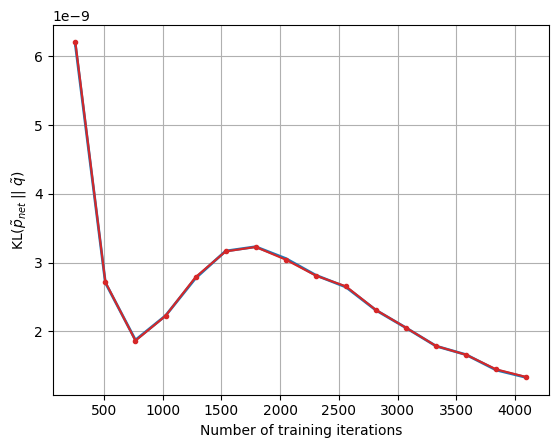

In [70]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0", linewidth=2)
plt.plot(n_iterations, results, ".-", color="C3", zorder=100)
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

## Continuous KL divergence

### Helper functions

#### Grid creation

In [5]:
def create_grid_samples(grid_resolution, 
                        x_centre=fig1_kwargs["view_x"], y_centre=fig1_kwargs["view_y"], 
                        x_side=2*fig1_kwargs["view_size"], y_side=2*fig1_kwargs["view_size"]):
    grid_x = torch.linspace(x_centre - x_side/2, x_centre + x_side/2, 
                            grid_resolution, device=device)
    grid_y = torch.linspace(y_centre - y_side/2, y_centre + y_side/2, 
                            grid_resolution, device=device)
    samples_x, samples_y = torch.meshgrid(grid_x, grid_y, indexing='xy')
    return torch.stack([samples_x, samples_y]).swapaxes(0,2) # (X_Index, Y_Index, X_Y)

#### Simpson composite numeric integration method

In [6]:
def get_simpson_params(grid_resolution, 
                       y_side=2*fig1_kwargs["view_size"], x_side=2*fig1_kwargs["view_size"]):
    
    simpson_vector = torch.ones(grid_resolution).to(device)
    simpson_vector[1::2] = 4
    simpson_vector[2:-2:2] = 2
    simpson_matrix = torch.kron(simpson_vector, simpson_vector.reshape(1,grid_resolution)).reshape((grid_resolution, grid_resolution))

    delta_x = x_side / (grid_resolution-1)
    delta_y = y_side / (grid_resolution-1)
    simpson_scale = delta_x * delta_y / 9

    return simpson_matrix, simpson_scale

##### Check that the integration method works

0.9999969375


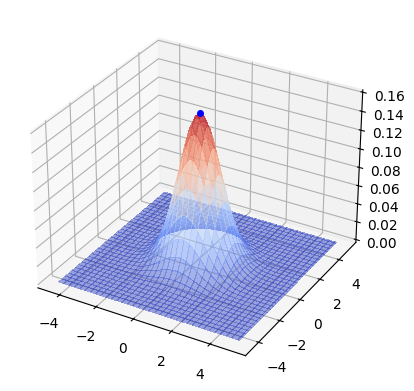

In [7]:
# Parameters
grid_resolution = 101
zoom_out = 8

# Secondary parameters
x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

# Create a grid
samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
samples_x, samples_y = samples.swapaxes(0,2)
samples_x = samples_x.cpu().numpy()
samples_y = samples_y.cpu().numpy()

# Define a multivariate normal distribution and sample from its pdf
normd = multivariate_normal((fig1_kwargs["view_x"], fig1_kwargs["view_y"]), [1,1])
f_samples = normd.pdf(np.dstack((samples_x, samples_y)))

# Plot to make sure it's an actual Gaussian
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(samples_x, samples_y, f_samples, 
                       cmap="coolwarm", linewidth=0, antialiased=False, alpha=.5)
ax.plot(fig1_kwargs["view_x"], fig1_kwargs["view_y"], zs=float(np.max(f_samples)), 
        marker=".", markersize=8, color="blue", linewidth=2, zorder=100)

# Basic parameters for Simpson composite 2D integration
simpson_matrix, simpson_scale = get_simpson_params(grid_resolution, x_side, y_side)

# Integrate the PDF --> The result should be 1, because it's normalized
print(float(torch.sum(simpson_matrix * torch.Tensor(f_samples).to(device))) * simpson_scale)

### Integral argument

In [7]:
def get_normalization_factor(model, sigma, grid_resolution, 
                             centre=(fig1_kwargs["view_x"], fig1_kwargs["view_y"]), 
                             sides=(2*fig1_kwargs["view_size"], 2*fig1_kwargs["view_size"])):
    
    # Create the grid
    samples = create_grid_samples(grid_resolution, *centre, *sides)

    # Get logarithm of the probabilities
    logp_samples = model.logp(samples, sigma=sigma)
    # Sigma = 0 for ground truth
    # Sigma = Sigma_Max for Gaussian noise

    # Basic parameters for Simpson composite 2D integration
    simpson_matrix, simpson_scale = get_simpson_params(grid_resolution, *sides)

    # Integrate the probability distribution
    normp = float(torch.sum(simpson_matrix * torch.exp(logp_samples))) * simpson_scale

    return normp

In [8]:
def KL_div_integral_argument(samples, model, model_0, 
                             normalize=False, model_normp=None,
                             pure_Gaussian=True, sigma_min=sigma_min, sigma_max=sigma_max,
                             logging=False): # Samples are (x, y) points in the 2D plane

    # Basic configuration
    if pure_Gaussian: sigma = sigma_max
    else: sigma = sigma_min
    if normalize and model_normp is None: raise ValueError("Missing normalization factors")

    # Get logarithm of the probabilities
    model_logp = model.logp(samples, sigma=sigma) # Not normalized
    model_0_logp = model_0.logp(samples, sigma=sigma) # Normalized
    # Sigma = 0 for ground truth
    # Sigma = Sigma_Max for Gaussian noise
        
    if logging:
        idx_start = int(samples.shape[0] / 2)
        idx_end = idx_start+10
        idx_mid = idx_start+5
        print("Samples", samples[idx_start:idx_end,idx_mid])
        print("Ground Truth Logp", model_0_logp[idx_start:idx_end,idx_mid])
        print("Model's Logp", model_logp[idx_start:idx_end,idx_mid])
        print("Model's Max Logp", max(model_logp[idx_start:idx_end,idx_mid]))
        print("Model's Min Logp", min(model_logp[idx_start:idx_end,idx_mid]))
        print("Model's p", torch.exp( model_logp )[idx_start:idx_end,idx_mid])

    # Normalize, if needed
    if normalize:
        model_logp_normalized = model_logp - math.log(model_normp)
        model_p_normalized = torch.exp(model_logp) / model_normp
        
        if logging:
            print("Model's normalizing constant", model_normp )
            print("My old normalizing constant", torch.sum( torch.exp(model_logp) ) )
            print("Model's Normalized p", model_p_normalized )
            print("Model's Max Normalized p", torch.max( model_p_normalized ) )
    
        return model_p_normalized * (model_logp_normalized - model_0_logp) # Using normalized distributions    
    return torch.exp( model_logp - torch.max(model_logp) ) * (model_logp - model_0_logp) # Should be faster and proportional

#### Vizualization functions

In [9]:
def plot_KL_divergence_integral_arg_surf(model, model_0, grid_resolution, 
                                         centre=(fig1_kwargs["view_x"], fig1_kwargs["view_y"]), 
                                         sides=(2*fig1_kwargs["view_size"], 2*fig1_kwargs["view_size"]),
                                         normalize=False, model_normp=None, alpha=1):

    # Create the grid
    samples = create_grid_samples(grid_resolution, *centre, *sides)

    # Evaluate the KL divergence function that we will integrate
    f_samples = KL_div_integral_argument(samples, model, model_0, normalize=normalize, 
                                         model_normp=model_normp)

    # Convert to Numpy to plot
    samples = samples.swapaxes(0,2).cpu().numpy()
    f_samples = f_samples.detach().cpu().numpy()

    # Plot surface
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(*samples, f_samples, cmap="coolwarm", linewidth=0, antialiased=False, alpha=alpha)

    return fig

In [10]:
def plot_KL_divergence_integral_arg_map(model, model_0, grid_resolution, 
                                        centre=(fig1_kwargs["view_x"], fig1_kwargs["view_y"]), 
                                        sides=(2*fig1_kwargs["view_size"], 2*fig1_kwargs["view_size"]),
                                        normalize=False, model_normp=None, 
                                        show_grid=False, dpi=400):

    # Create the grid
    samples = create_grid_samples(grid_resolution, *centre, *sides)
    fig_kwargs = {"view_x":centre[0], "view_y":centre[1], "view_size":sides[0]/2}

    # Evaluate the KL divergence function that we will integrate
    f_samples = KL_div_integral_argument(samples, model, model_0, 
                                         normalize=normalize, model_normp=model_normp)

    # Convert to Numpy to plot
    samples = samples.swapaxes(0,2).cpu().numpy()
    f_samples = f_samples.detach().cpu().numpy()

    # Plot colormap on top of the ground truth distribution
    fig = plt.figure(dpi=dpi)
    plt.pcolormesh(*samples, f_samples)
    fig.axes[0].set_aspect("equal")
    plt.colorbar()
    toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'}, figure=fig, **fig_kwargs)
    if show_grid:
        plt.scatter(*samples.reshape((grid_resolution**2, 2)).swapaxes(0,1), 
                    edgecolor="none", facecolor="white", s=0.1, marker=".")
    plt.gca().set_axis_on()
    
    return fig

### Examine the integral argument

In [24]:
fig1_kwargs

{'view_x': 0.3,
 'view_y': 0.3,
 'view_size': 1.2,
 'device': device(type='cuda', index=0)}

#### Zoom out = 1

In [12]:
grid_resolution = 401
zoom_out = 1

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

f_samples = KL_div_integral_argument(samples, guide, gtd, logging=True)

del samples, f_samples

Samples tensor([[0.3000, 0.3300],
        [0.3060, 0.3300],
        [0.3120, 0.3300],
        [0.3180, 0.3300],
        [0.3240, 0.3300],
        [0.3300, 0.3300],
        [0.3360, 0.3300],
        [0.3420, 0.3300],
        [0.3480, 0.3300],
        [0.3540, 0.3300]], device='cuda:0')
Ground Truth Logp tensor([-5.0614, -5.0614, -5.0614, -5.0614, -5.0614, -5.0614, -5.0613, -5.0613,
        -5.0613, -5.0613], device='cuda:0')
Model's Logp tensor([0.3196, 0.3196, 0.3196, 0.3195, 0.3195, 0.3195, 0.3195, 0.3195, 0.3195,
        0.3195], device='cuda:0')
Model's Max Logp tensor(0.3196, device='cuda:0')
Model's Min Logp tensor(0.3195, device='cuda:0')
Model's p tensor([1.3765, 1.3765, 1.3765, 1.3765, 1.3765, 1.3765, 1.3765, 1.3764, 1.3764,
        1.3764], device='cuda:0')


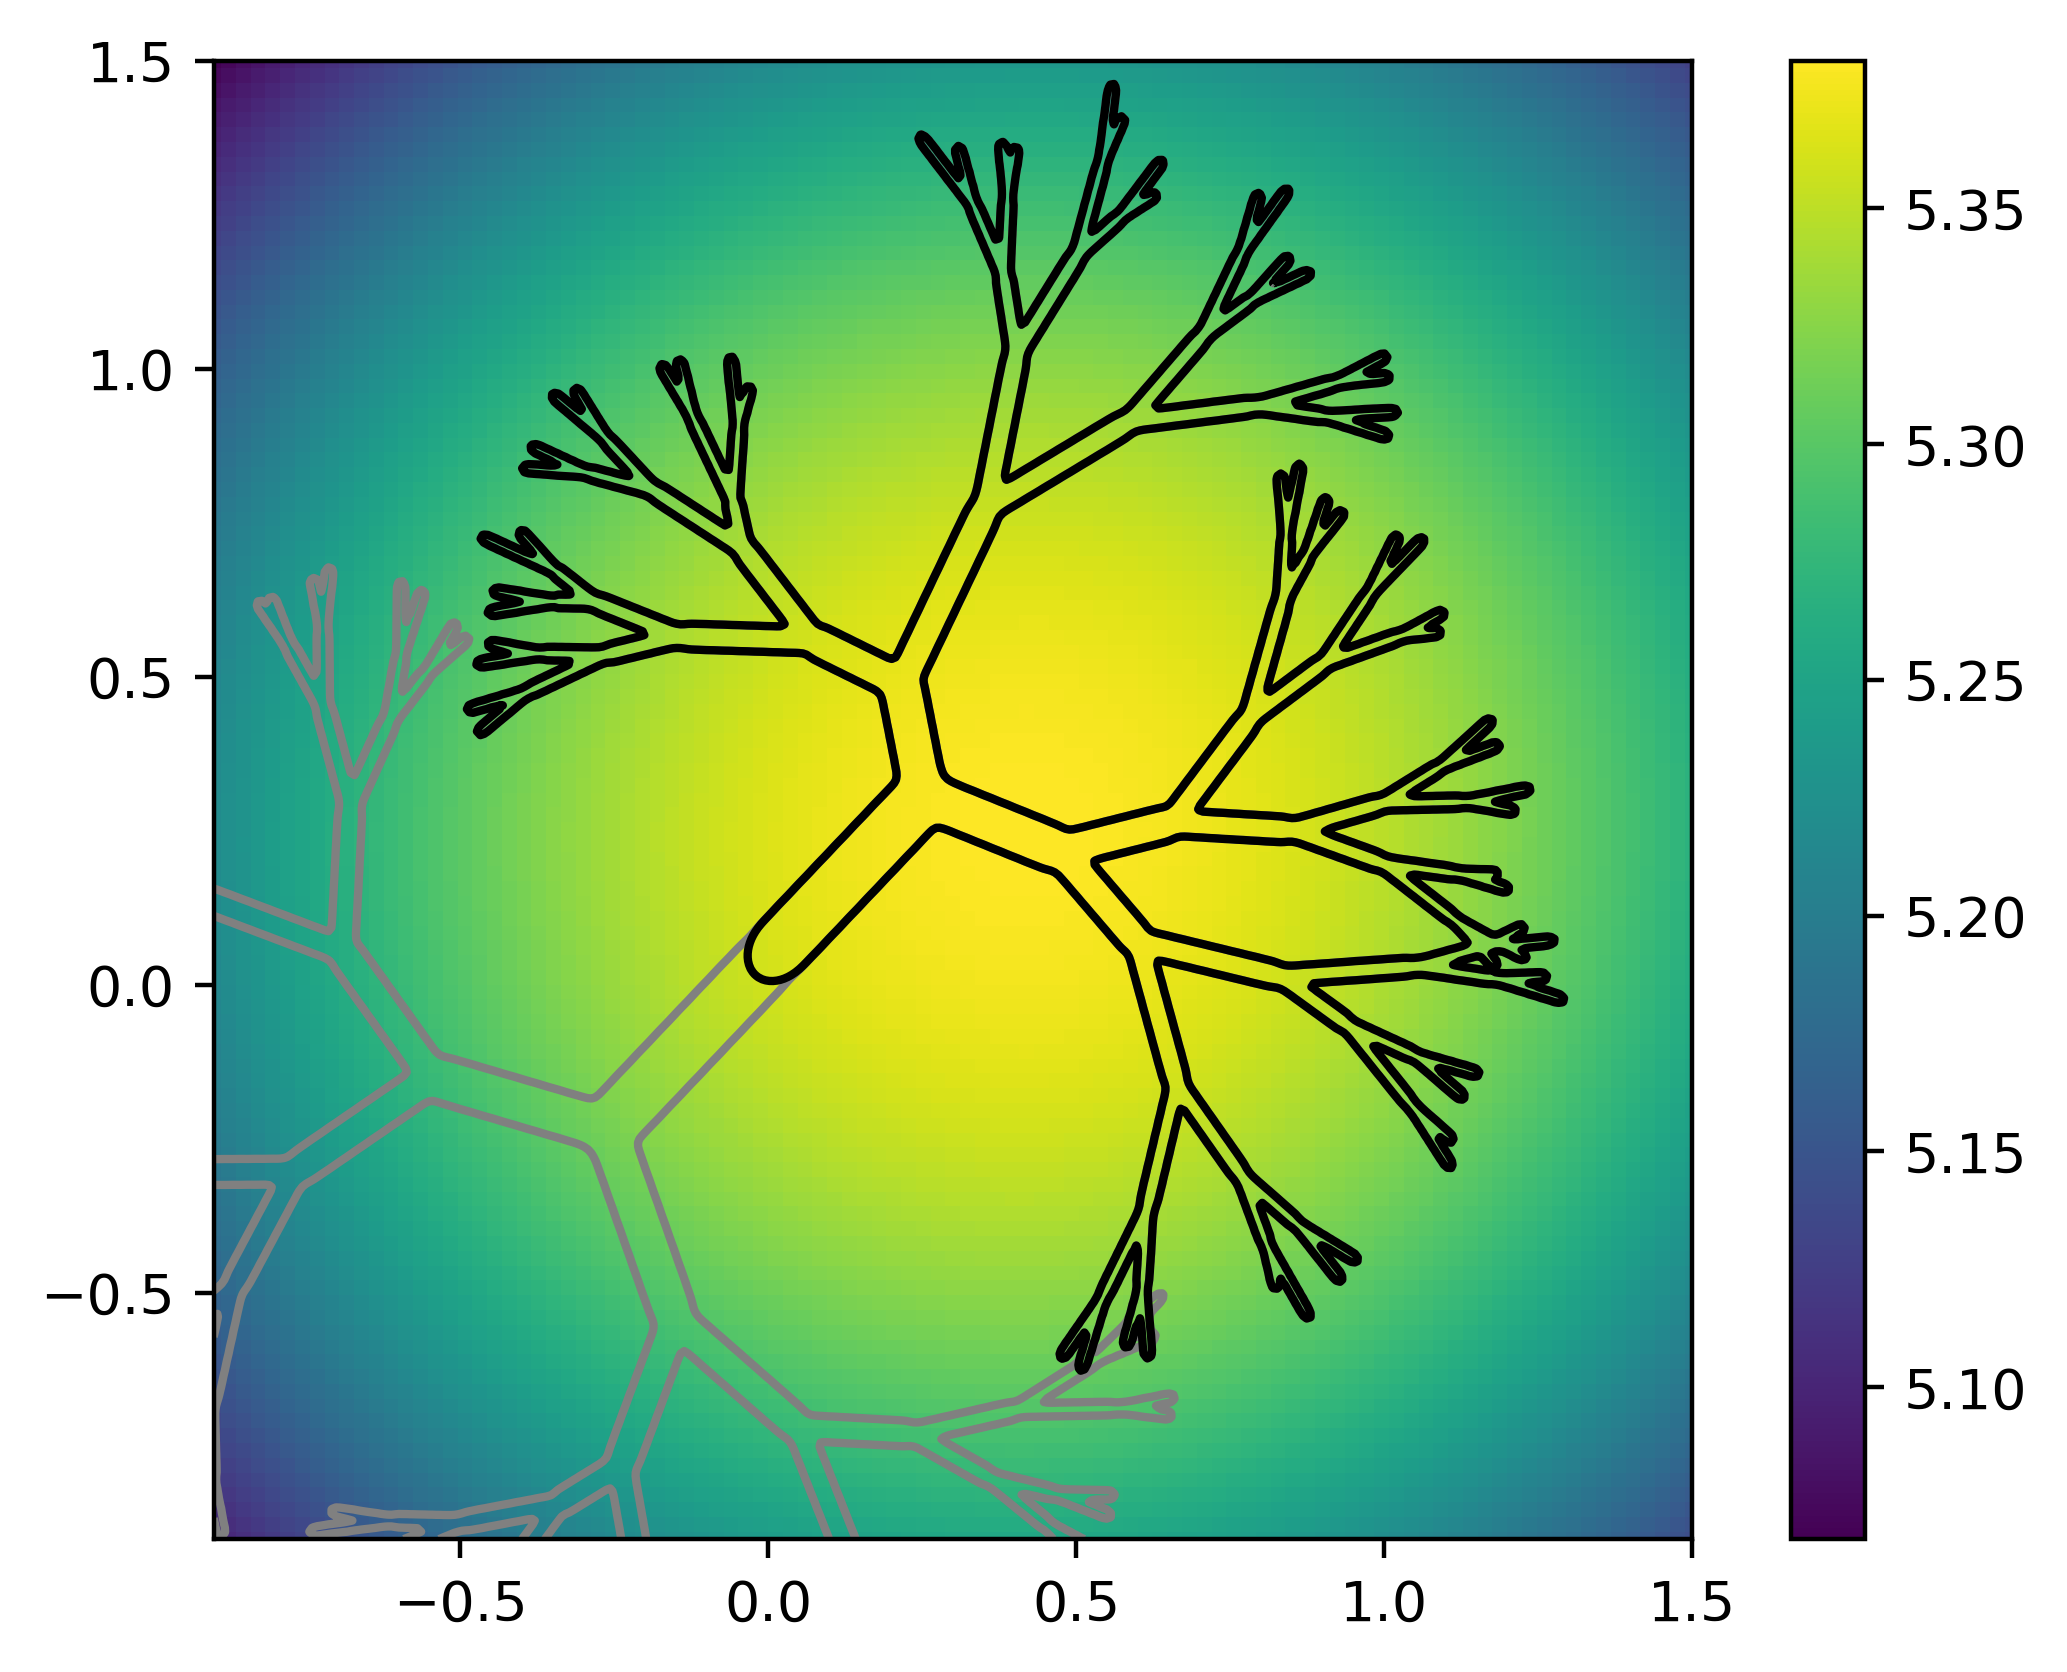

In [9]:
grid_resolution = 101
zoom_out = 1

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_map(guide, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side), show_grid=False);

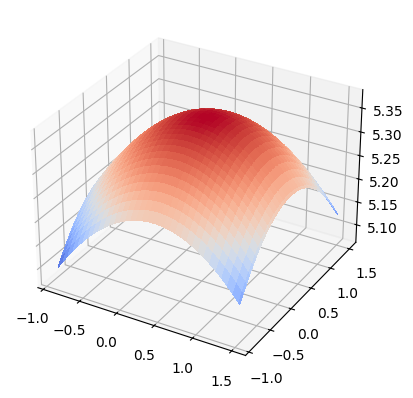

In [30]:
grid_resolution = 101
zoom_out = 1

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_surf(guide, gtd, grid_resolution, 
                                     (x_centre, y_centre), (x_side, y_side));

#### Zoom out = 8

In [27]:
grid_resolution = 101
zoom_out = 8

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

f_samples = KL_div_integral_argument(samples, guide, gtd, logging=True)

del samples, f_samples

Samples tensor([[0.3000, 1.2600],
        [0.4920, 1.2600],
        [0.6840, 1.2600],
        [0.8760, 1.2600],
        [1.0680, 1.2600],
        [1.2600, 1.2600],
        [1.4520, 1.2600],
        [1.6440, 1.2600],
        [1.8360, 1.2600],
        [2.0280, 1.2600]], device='cuda:0')
Ground Truth Logp tensor([-5.0774, -5.0776, -5.0792, -5.0823, -5.0869, -5.0930, -5.1005, -5.1095,
        -5.1200, -5.1320], device='cuda:0')
Model's Logp tensor([0.3064, 0.3056, 0.3034, 0.3000, 0.2952, 0.2891, 0.2817, 0.2730, 0.2629,
        0.2515], device='cuda:0')
Model's Max Logp tensor(0.3064, device='cuda:0')
Model's Min Logp tensor(0.2515, device='cuda:0')
Model's p tensor([1.3585, 1.3574, 1.3545, 1.3498, 1.3434, 1.3352, 1.3254, 1.3138, 1.3007,
        1.2860], device='cuda:0')


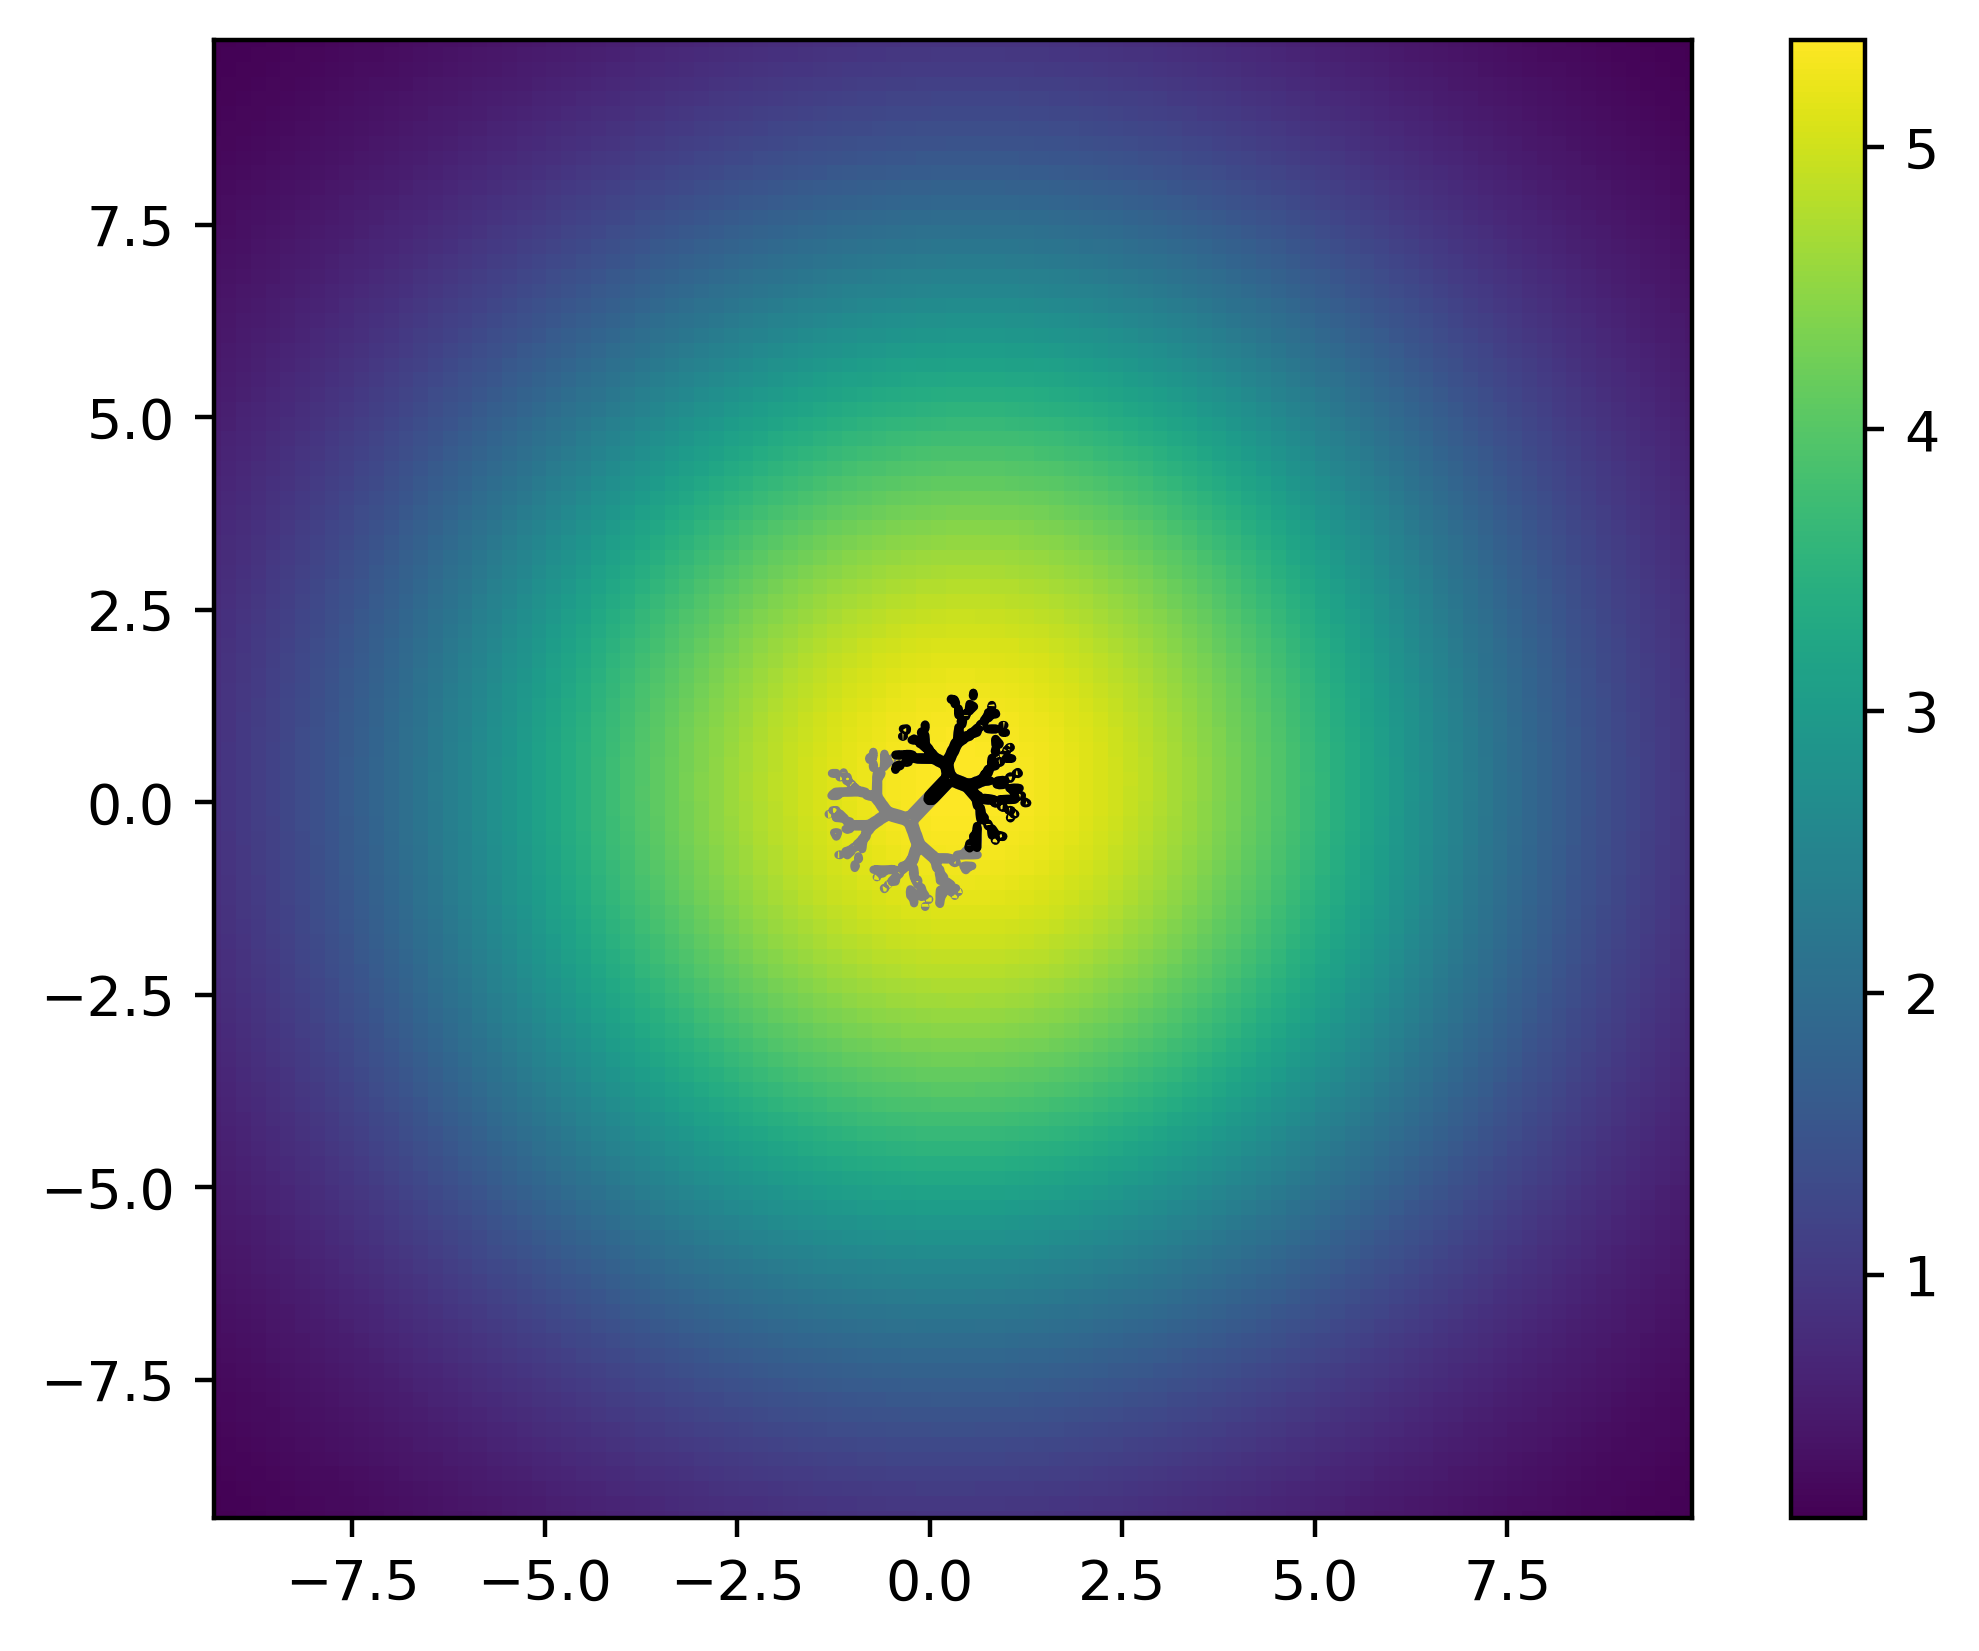

In [24]:
grid_resolution = 101
zoom_out = 8

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_map(guide, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side), show_grid=False);

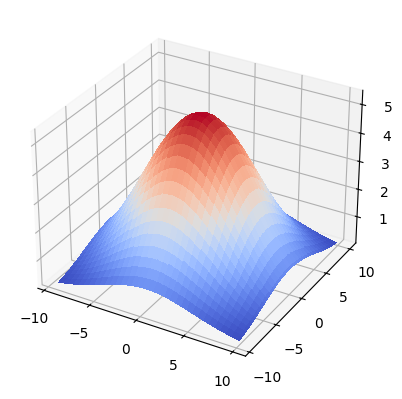

In [16]:
grid_resolution = 101
zoom_out = 8

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_surf(guide, gtd, grid_resolution, 
                                     (x_centre, y_centre), (x_side, y_side));

#### Normalizing zoom out = 16

In [12]:
grid_resolution = 101
zoom_out = 16
normalize = False

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

f_samples = KL_div_integral_argument(samples, guide, gtd, logging=True, normalize=normalize)

del samples, f_samples

Samples tensor([[0.3000, 2.2200],
        [0.6840, 2.2200],
        [1.0680, 2.2200],
        [1.4520, 2.2200],
        [1.8360, 2.2200],
        [2.2200, 2.2200],
        [2.6040, 2.2200],
        [2.9880, 2.2200],
        [3.3720, 2.2200],
        [3.7560, 2.2200]], device='cuda:0')
Ground Truth Logp tensor([-5.1299, -5.1318, -5.1395, -5.1532, -5.1726, -5.1980, -5.2292, -5.2663,
        -5.3093, -5.3581], device='cuda:0')
Model's Logp tensor([0.2591, 0.2562, 0.2481, 0.2348, 0.2161, 0.1922, 0.1630, 0.1284, 0.0884,
        0.0428], device='cuda:0')
Model's Max Logp tensor(0.2591, device='cuda:0')
Model's Min Logp tensor(0.0428, device='cuda:0')
Model's p tensor([1.2957, 1.2921, 1.2816, 1.2646, 1.2413, 1.2120, 1.1770, 1.1370, 1.0924,
        1.0437], device='cuda:0')


In [13]:
grid_resolution = 101
zoom_out = 16
normalize = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

f_samples = KL_div_integral_argument(samples, guide, gtd, logging=True, normalize=normalize)

del samples, f_samples

Samples tensor([[0.3000, 2.2200],
        [0.6840, 2.2200],
        [1.0680, 2.2200],
        [1.4520, 2.2200],
        [1.8360, 2.2200],
        [2.2200, 2.2200],
        [2.6040, 2.2200],
        [2.9880, 2.2200],
        [3.3720, 2.2200],
        [3.7560, 2.2200]], device='cuda:0')
Ground Truth Logp tensor([-5.1299, -5.1318, -5.1395, -5.1532, -5.1726, -5.1980, -5.2292, -5.2663,
        -5.3093, -5.3581], device='cuda:0')
Model's Logp tensor([0.2591, 0.2562, 0.2481, 0.2348, 0.2161, 0.1922, 0.1630, 0.1284, 0.0884,
        0.0428], device='cuda:0')
Model's Max Logp tensor(0.2591, device='cuda:0')
Model's Min Logp tensor(0.0428, device='cuda:0')
Model's p tensor([1.2957, 1.2921, 1.2816, 1.2646, 1.2413, 1.2120, 1.1770, 1.1370, 1.0924,
        1.0437], device='cuda:0')
Model's Normalized p tensor([[6.4405e-10, 8.4802e-10, 1.1101e-09,  ..., 9.0772e-10, 6.9029e-10,
         5.2183e-10],
        [8.4487e-10, 1.1124e-09, 1.4562e-09,  ..., 1.2059e-09, 9.1678e-10,
         6.9286e-10],
        

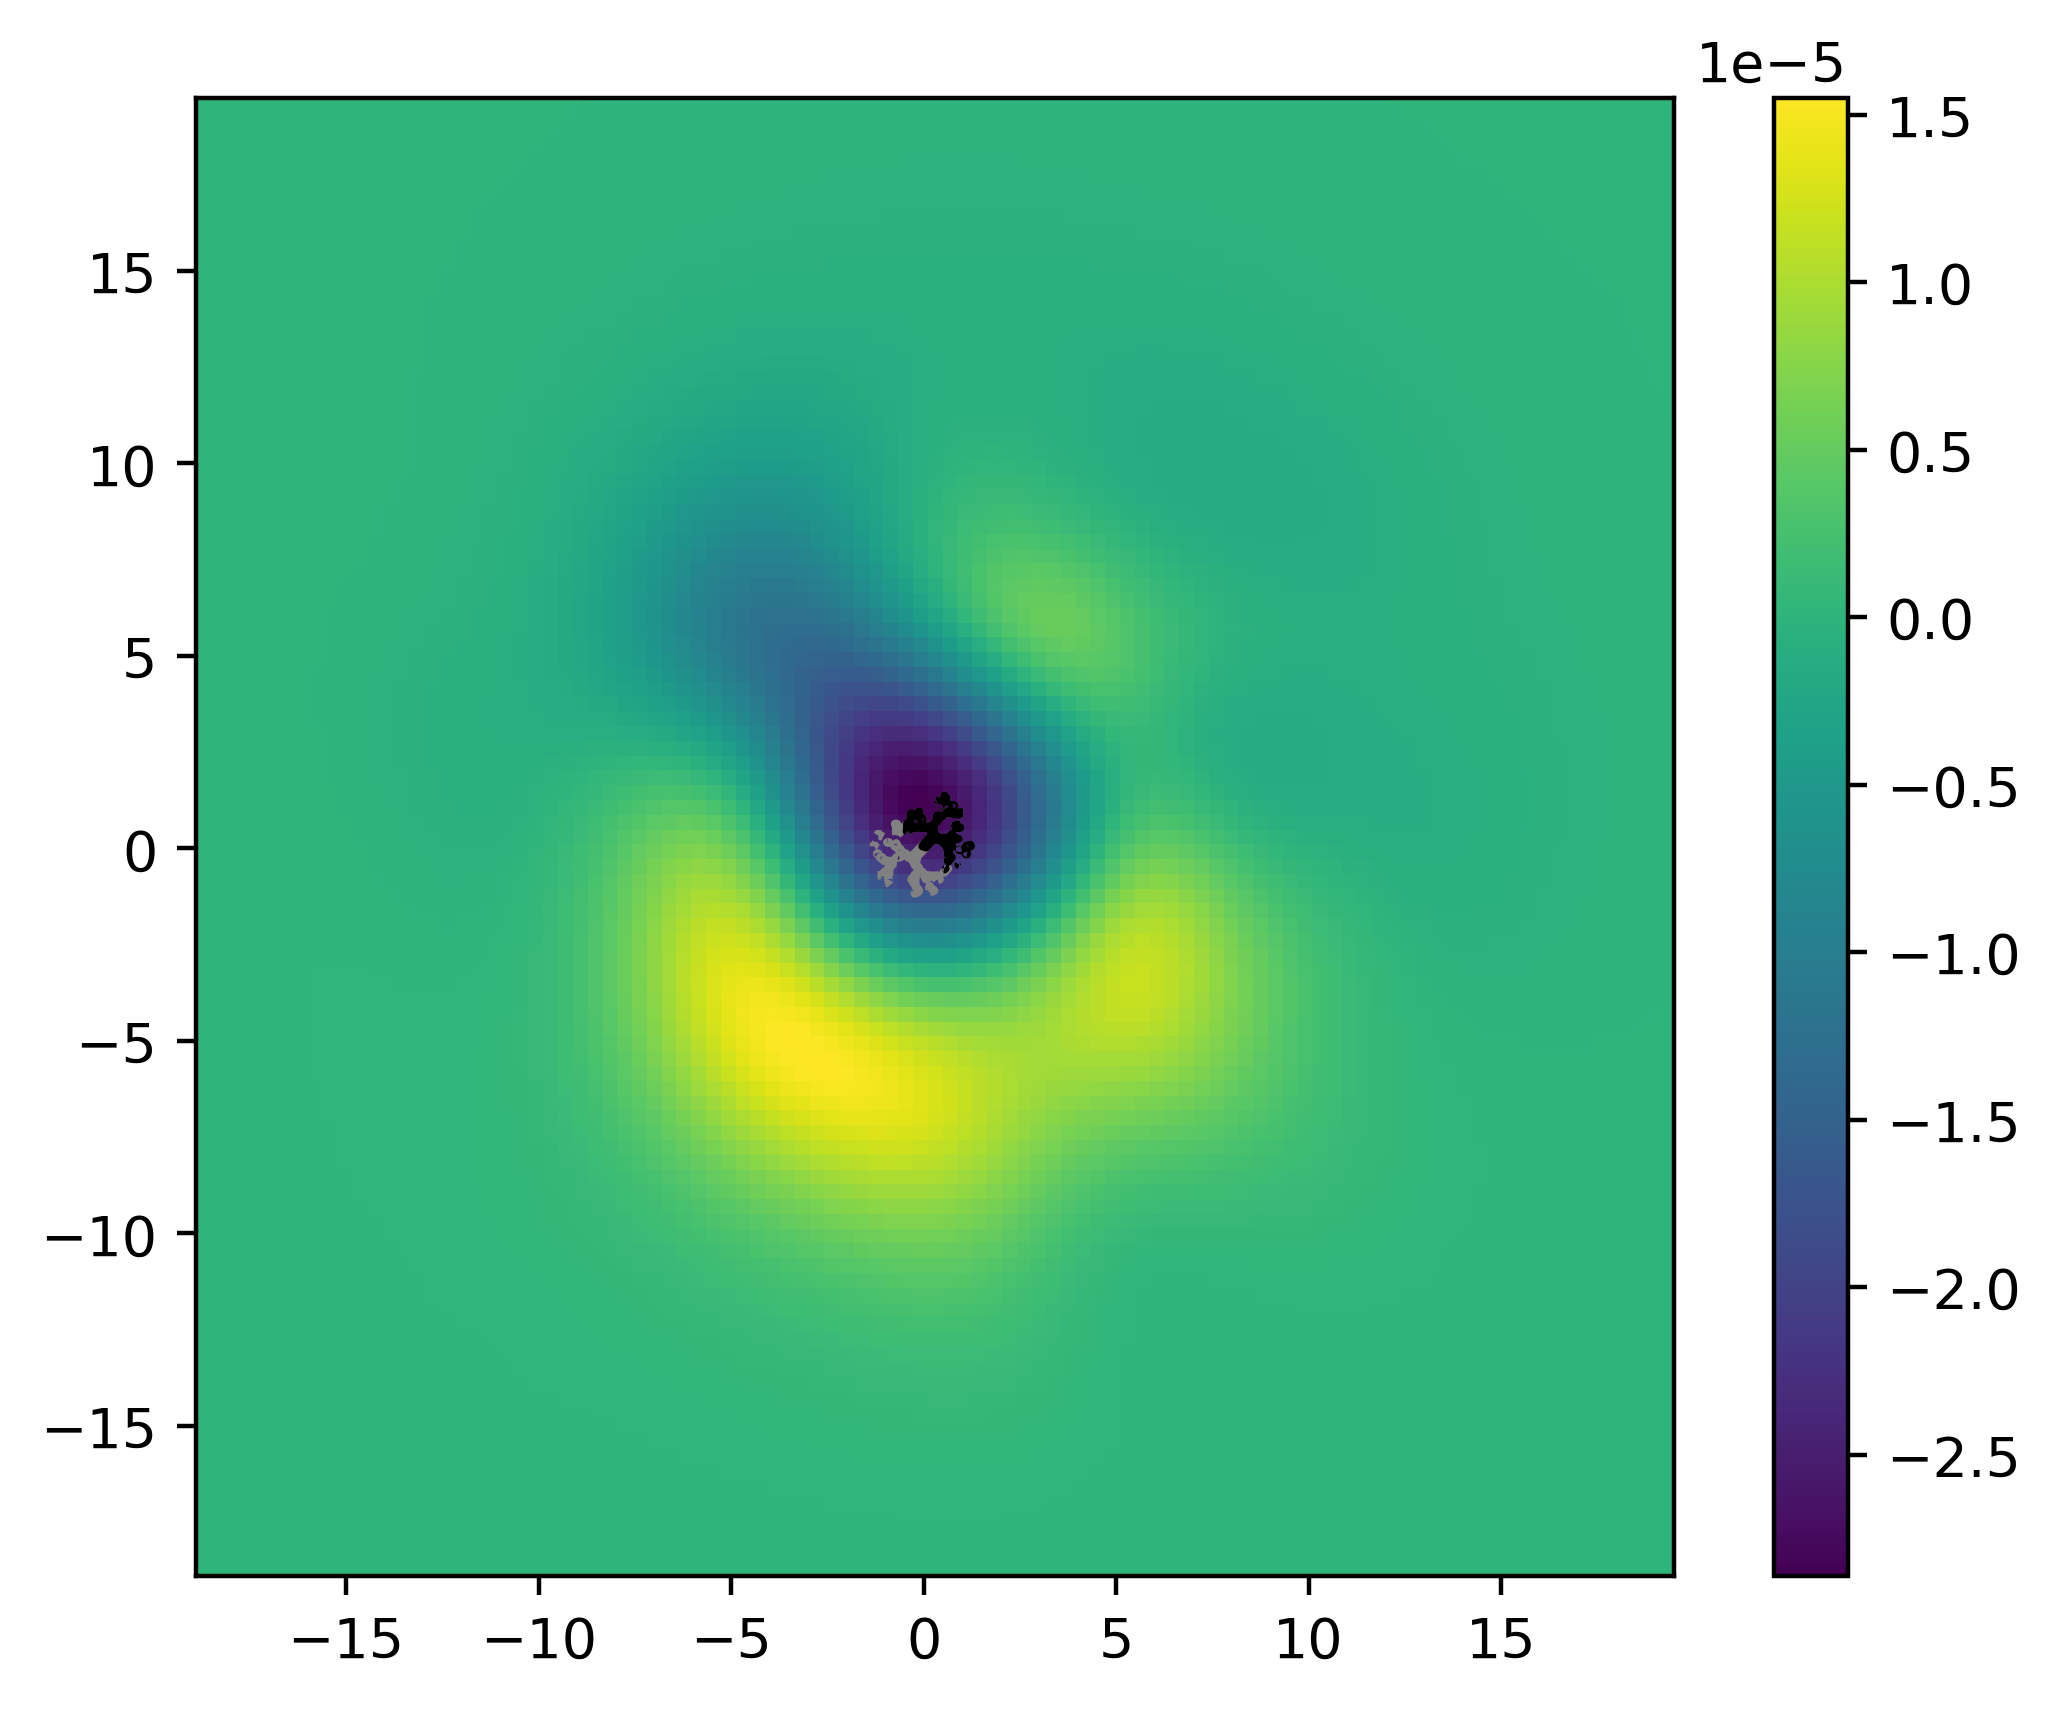

In [28]:
grid_resolution = 101
zoom_out = 16
normalize = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_map(guide, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side), show_grid=False, 
                                    normalize=normalize);

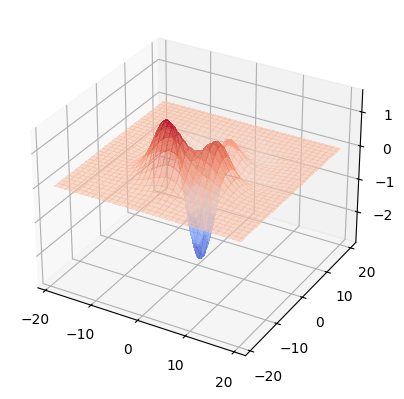

In [27]:
grid_resolution = 101
zoom_out = 16

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

plot_KL_divergence_integral_arg_surf(guide, gtd, grid_resolution, 
                                     (x_centre, y_centre), (x_side, y_side),
                                     normalize=True, alpha=.5);

#### Normalized, sigma_min, zoom out = 16

In [11]:
grid_resolution = 101
zoom_out = 16
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

if normalize: 

    # Define sigma
    if pure_Gaussian: sigma = sigma_max
    else: sigma = sigma_min

    # Get normalization factors
    guide_normp = get_normalization_factor(guide, sigma, grid_resolution, 
                                           (x_centre, y_centre), (x_side, y_side))

else: guide_normp = None

f_samples = KL_div_integral_argument(samples, guide, gtd, normalize=normalize, model_normp=guide_normp, 
                                     pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max,
                                     logging=True)

del samples, f_samples

Samples tensor([[0.3000, 2.2200],
        [0.6840, 2.2200],
        [1.0680, 2.2200],
        [1.4520, 2.2200],
        [1.8360, 2.2200],
        [2.2200, 2.2200],
        [2.6040, 2.2200],
        [2.9880, 2.2200],
        [3.3720, 2.2200],
        [3.7560, 2.2200]], device='cuda:0')
Ground Truth Logp tensor([-5.1299, -5.1318, -5.1395, -5.1532, -5.1726, -5.1980, -5.2292, -5.2663,
        -5.3093, -5.3581], device='cuda:0')
Model's Logp tensor([0.2591, 0.2562, 0.2481, 0.2348, 0.2161, 0.1922, 0.1630, 0.1284, 0.0884,
        0.0428], device='cuda:0')
Model's Max Logp tensor(0.2591, device='cuda:0')
Model's Min Logp tensor(0.0428, device='cuda:0')
Model's p tensor([1.2957, 1.2921, 1.2816, 1.2646, 1.2413, 1.2120, 1.1770, 1.1370, 1.0924,
        1.0437], device='cuda:0')
Model's normalizing constant 223.69238399999998
My old normalizing constant tensor(1517.0693, device='cuda:0')
Model's Normalized p tensor([[4.3679e-09, 5.7512e-09, 7.5288e-09,  ..., 6.1561e-09, 4.6815e-09,
         3.5390e

##### Old

In [ ]:
grid_resolution = 101
zoom_out = 16
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = False

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]
fig_kwargs = {"view_x":x_centre, "view_y":y_centre, "view_size":x_side/2, "device":torch.device('cuda:1')}

samples = create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)

if normalize: 

    # Define sigma
    if pure_Gaussian: sigma = sigma_max
    else: sigma = sigma_min

    # Get normalization factors
    guide_normp = get_normalization_factor(guide, sigma, grid_resolution, 
                                           x_centre, y_centre, x_side, y_side)

f_samples = KL_div_integral_argument(samples, guide, gtd, normalize=normalize, 
                                     model_normp=guide_normp,
                                     pure_Gaussian=False, sigma_min=sigma_min, sigma_max=sigma_max,
                                     logging=True)

del samples, f_samples

Samples tensor([[0.3000, 2.2200],
        [0.6840, 2.2200],
        [1.0680, 2.2200],
        [1.4520, 2.2200],
        [1.8360, 2.2200],
        [2.2200, 2.2200],
        [2.6040, 2.2200],
        [2.9880, 2.2200],
        [3.3720, 2.2200],
        [3.7560, 2.2200]], device='cuda:0')
Ground Truth Logp tensor([ -5.2393,  -5.2621,  -5.7648,  -6.7566,  -8.2429, -10.2312, -12.7320,
        -15.7563, -19.3137, -23.4115], device='cuda:0')
Model's Logp tensor([ -0.2518,  -0.2793,  -0.8163,  -2.0312,  -3.6447,  -5.2812,  -7.0194,
         -8.9186, -10.8285, -12.6545], device='cuda:0')
Model's Max Logp tensor(-0.2518, device='cuda:0')
Model's Min Logp tensor(-12.6545, device='cuda:0')
Model's p tensor([7.7742e-01, 7.5632e-01, 4.4207e-01, 1.3118e-01, 2.6129e-02, 5.0864e-03,
        8.9434e-04, 1.3388e-04, 1.9826e-05, 3.1932e-06], device='cuda:0')
Model's Normalized p tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        .

### Functions to estimate KL divergence by solving the integral numerically

In [ ]:
def estimate_KL_divergence(model, model_0, grid_resolution, 
                           centre=(fig1_kwargs["view_x"], fig1_kwargs["view_y"]), 
                           sides=(fig1_kwargs["view_size"], fig1_kwargs["view_size"]), 
                           normalize=False, model_normp=None,
                           pure_Gaussian=True, sigma_min=sigma_min, sigma_max=sigma_max,
                           map_plotting=False, surf_plotting=False, logging=False):

    # Basic parameters for Simpson composite 2D integration
    simpson_matrix, simpson_scale = get_simpson_params(grid_resolution, *sides)

    if normalize and model_normp is None:

        # Define sigma
        if pure_Gaussian: sigma = sigma_max
        else: sigma = sigma_min

        # Get normalization factors
        model_normp = get_normalization_factor(model, sigma, grid_resolution, 
                                            (x_centre, y_centre), (x_side, y_side))
        
    else: model_normp = None

    # Create the grid
    samples = create_grid_samples(grid_resolution, *centre, *sides)
    fig_kwargs = {"view_x":centre[0], "view_y":centre[1], "view_size":sides[0]/2}

    # Evaluate the KL divergence function that we will integrate
    f_samples = KL_div_integral_argument(samples, model, model_0, 
        normalize=normalize, model_normp=model_normp, 
        pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max,
        logging=logging)

    # Integrate
    kl_div = float(torch.sum(simpson_matrix * f_samples)) * simpson_scale
    if logging: print("KL div", kl_div)
    
    # Plot
    if surf_plotting or map_plotting:

        # Convert to Numpy to plot
        samples = samples.swapaxes(0,2).cpu().numpy()
        f_samples = f_samples.detach().cpu().numpy()

    if surf_plotting: # Plot surface
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(*samples, f_samples, cmap="coolwarm", 
                        linewidth=0, antialiased=False, alpha=0.5)

    if map_plotting: # Plot colormap on top of the ground truth distribution
        fig = plt.figure()
        plt.pcolormesh(*samples, f_samples)
        fig.axes[0].set_aspect("equal")
        plt.colorbar()
        toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'}, figure=fig, **fig_kwargs)
        plt.gca().set_axis_on()

    return kl_div

### Estimate KL divergence once

#### Unnormalized

KL div 879.181056


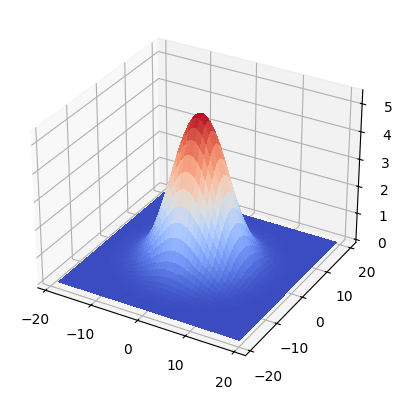

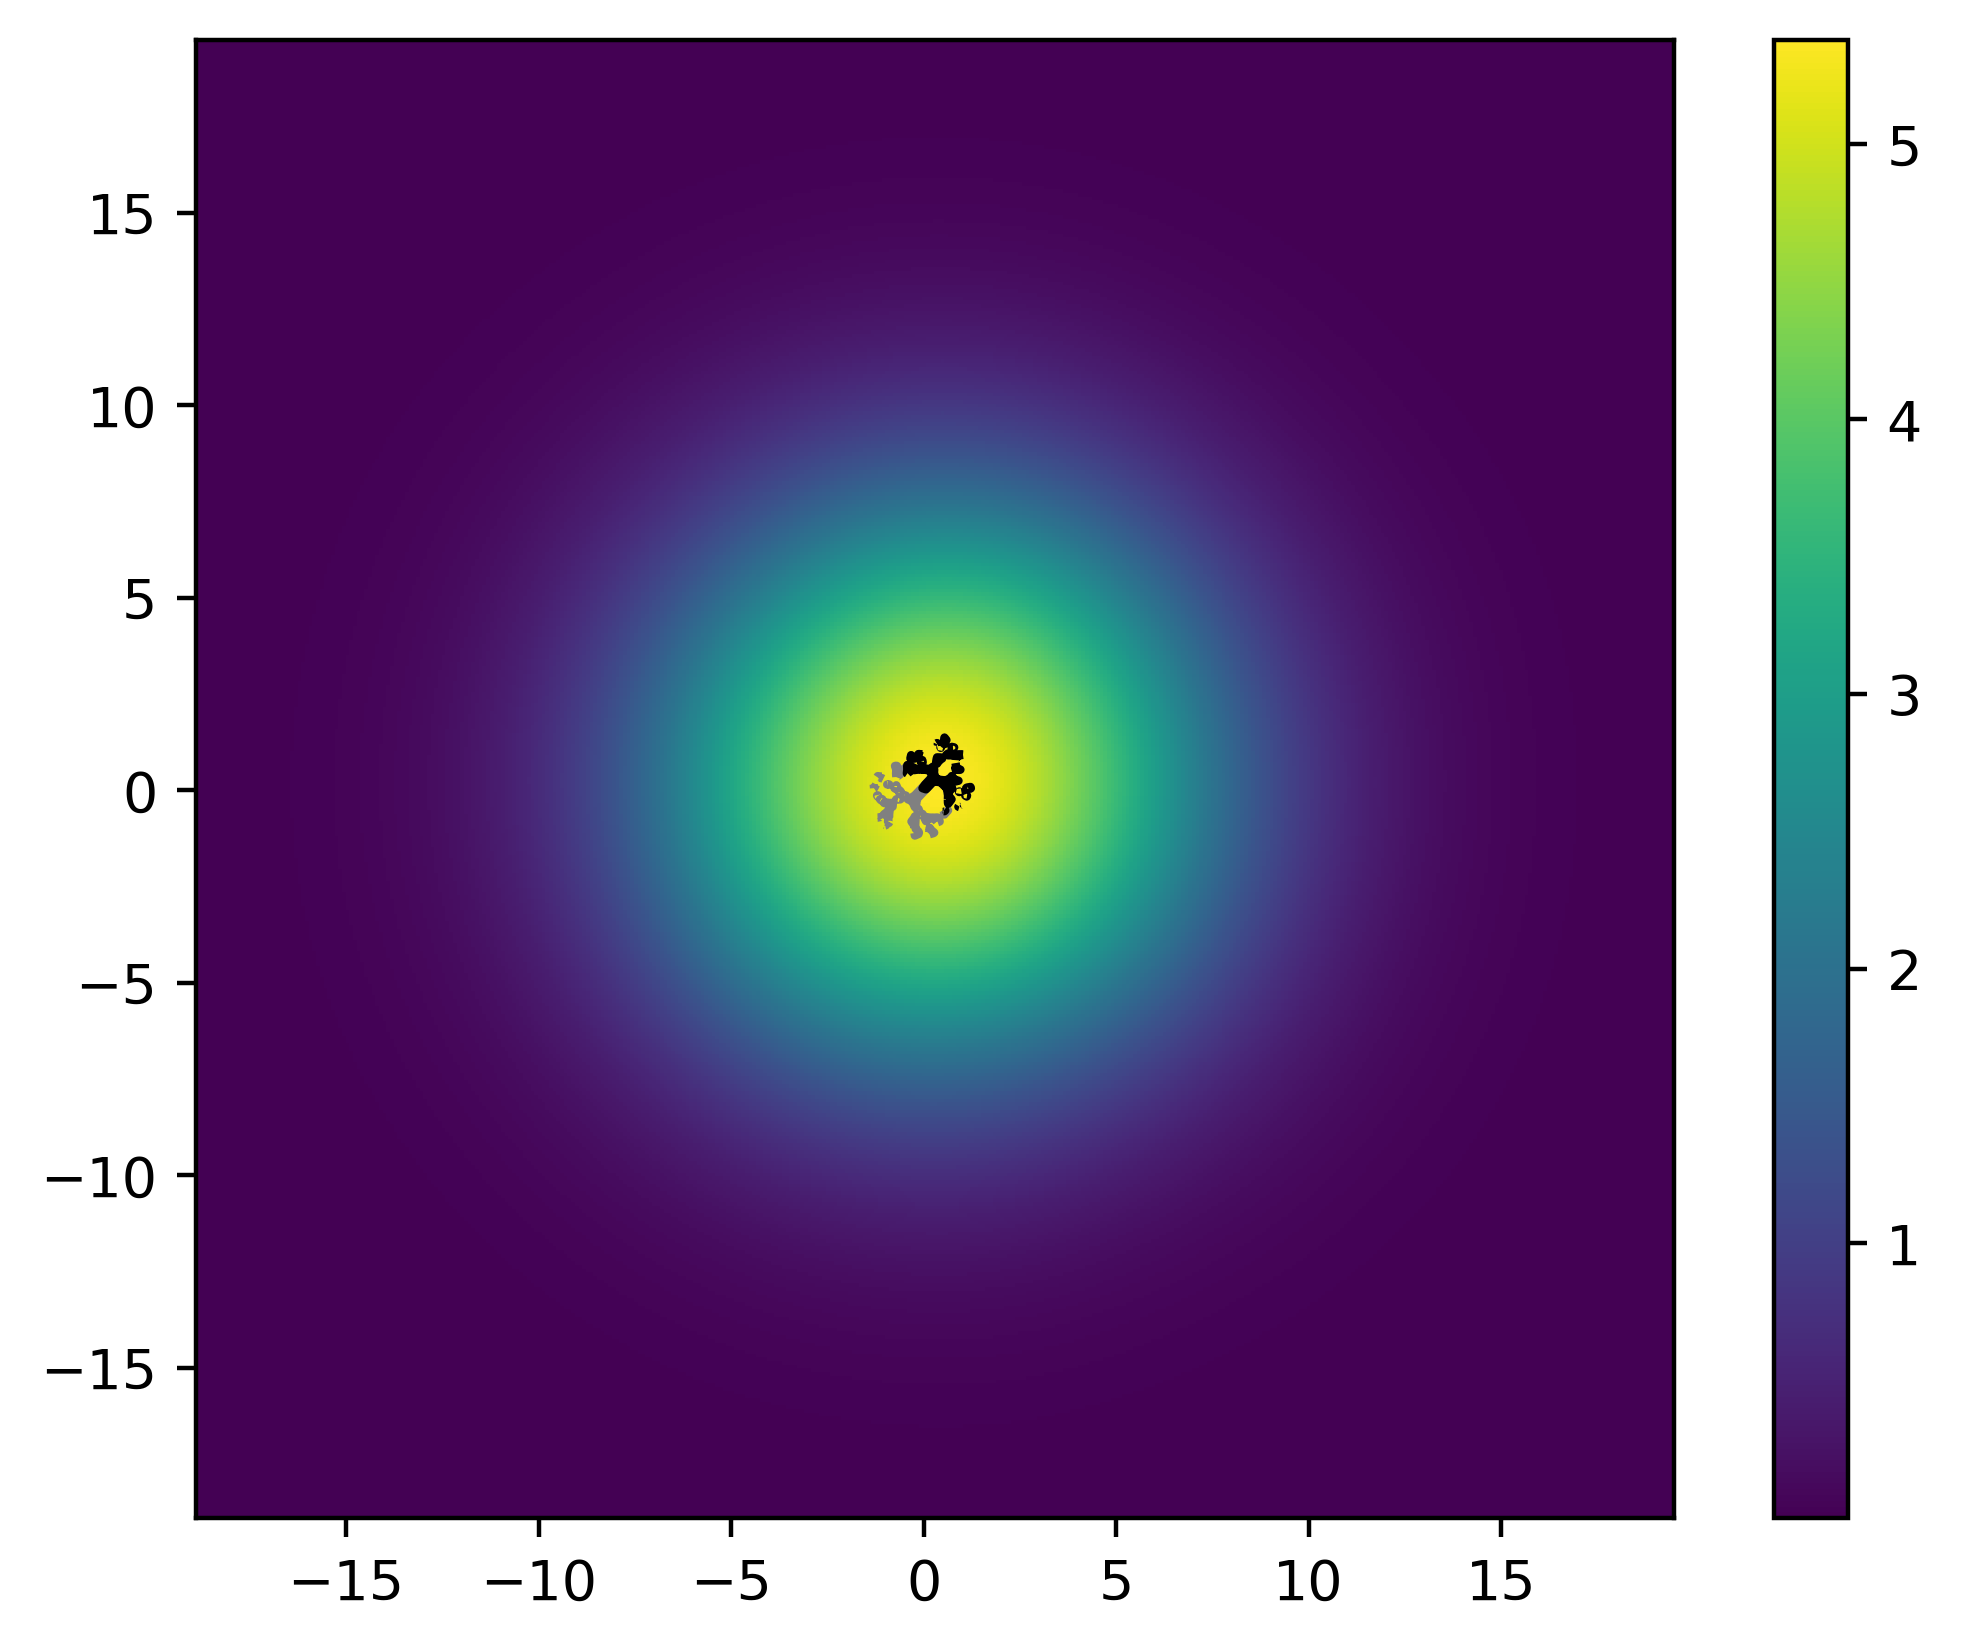

In [31]:
grid_resolution = 401
zoom_out = 32

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*fig1_kwargs["view_size"]

kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
                                (x_centre, y_centre), (x_side, y_side))
print("KL div", kl_div)

plot_KL_divergence_integral_arg_surf(guide, gtd, grid_resolution, 
                                     (x_centre, y_centre), (x_side, y_side));

plot_KL_divergence_integral_arg_map(guide, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side));

#### Normalized

KL div 0.0002976026058197022


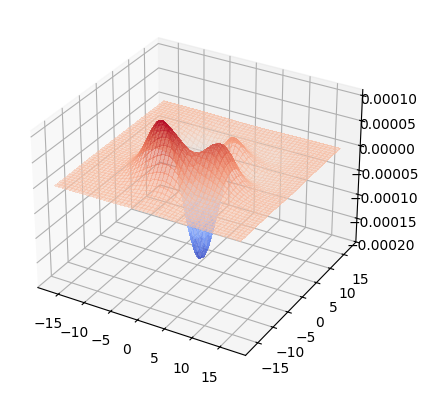

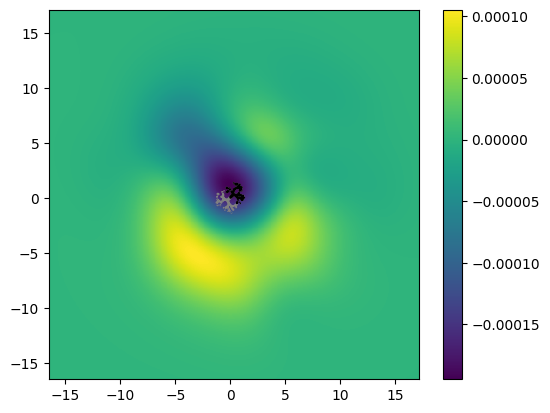

In [15]:
grid_resolution = 801
zoom_out = 28
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*fig1_kwargs["view_size"]

kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
                                (x_centre, y_centre), (x_side, y_side), 
                                normalize=normalize,
                                pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max,
                                map_plotting=True, surf_plotting=True)
print("KL div", kl_div)

##### Old normalized

KL div 5.257976651191712e-07


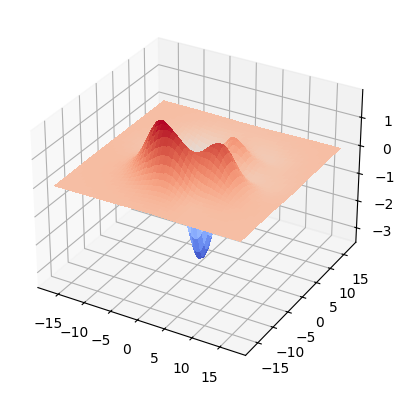

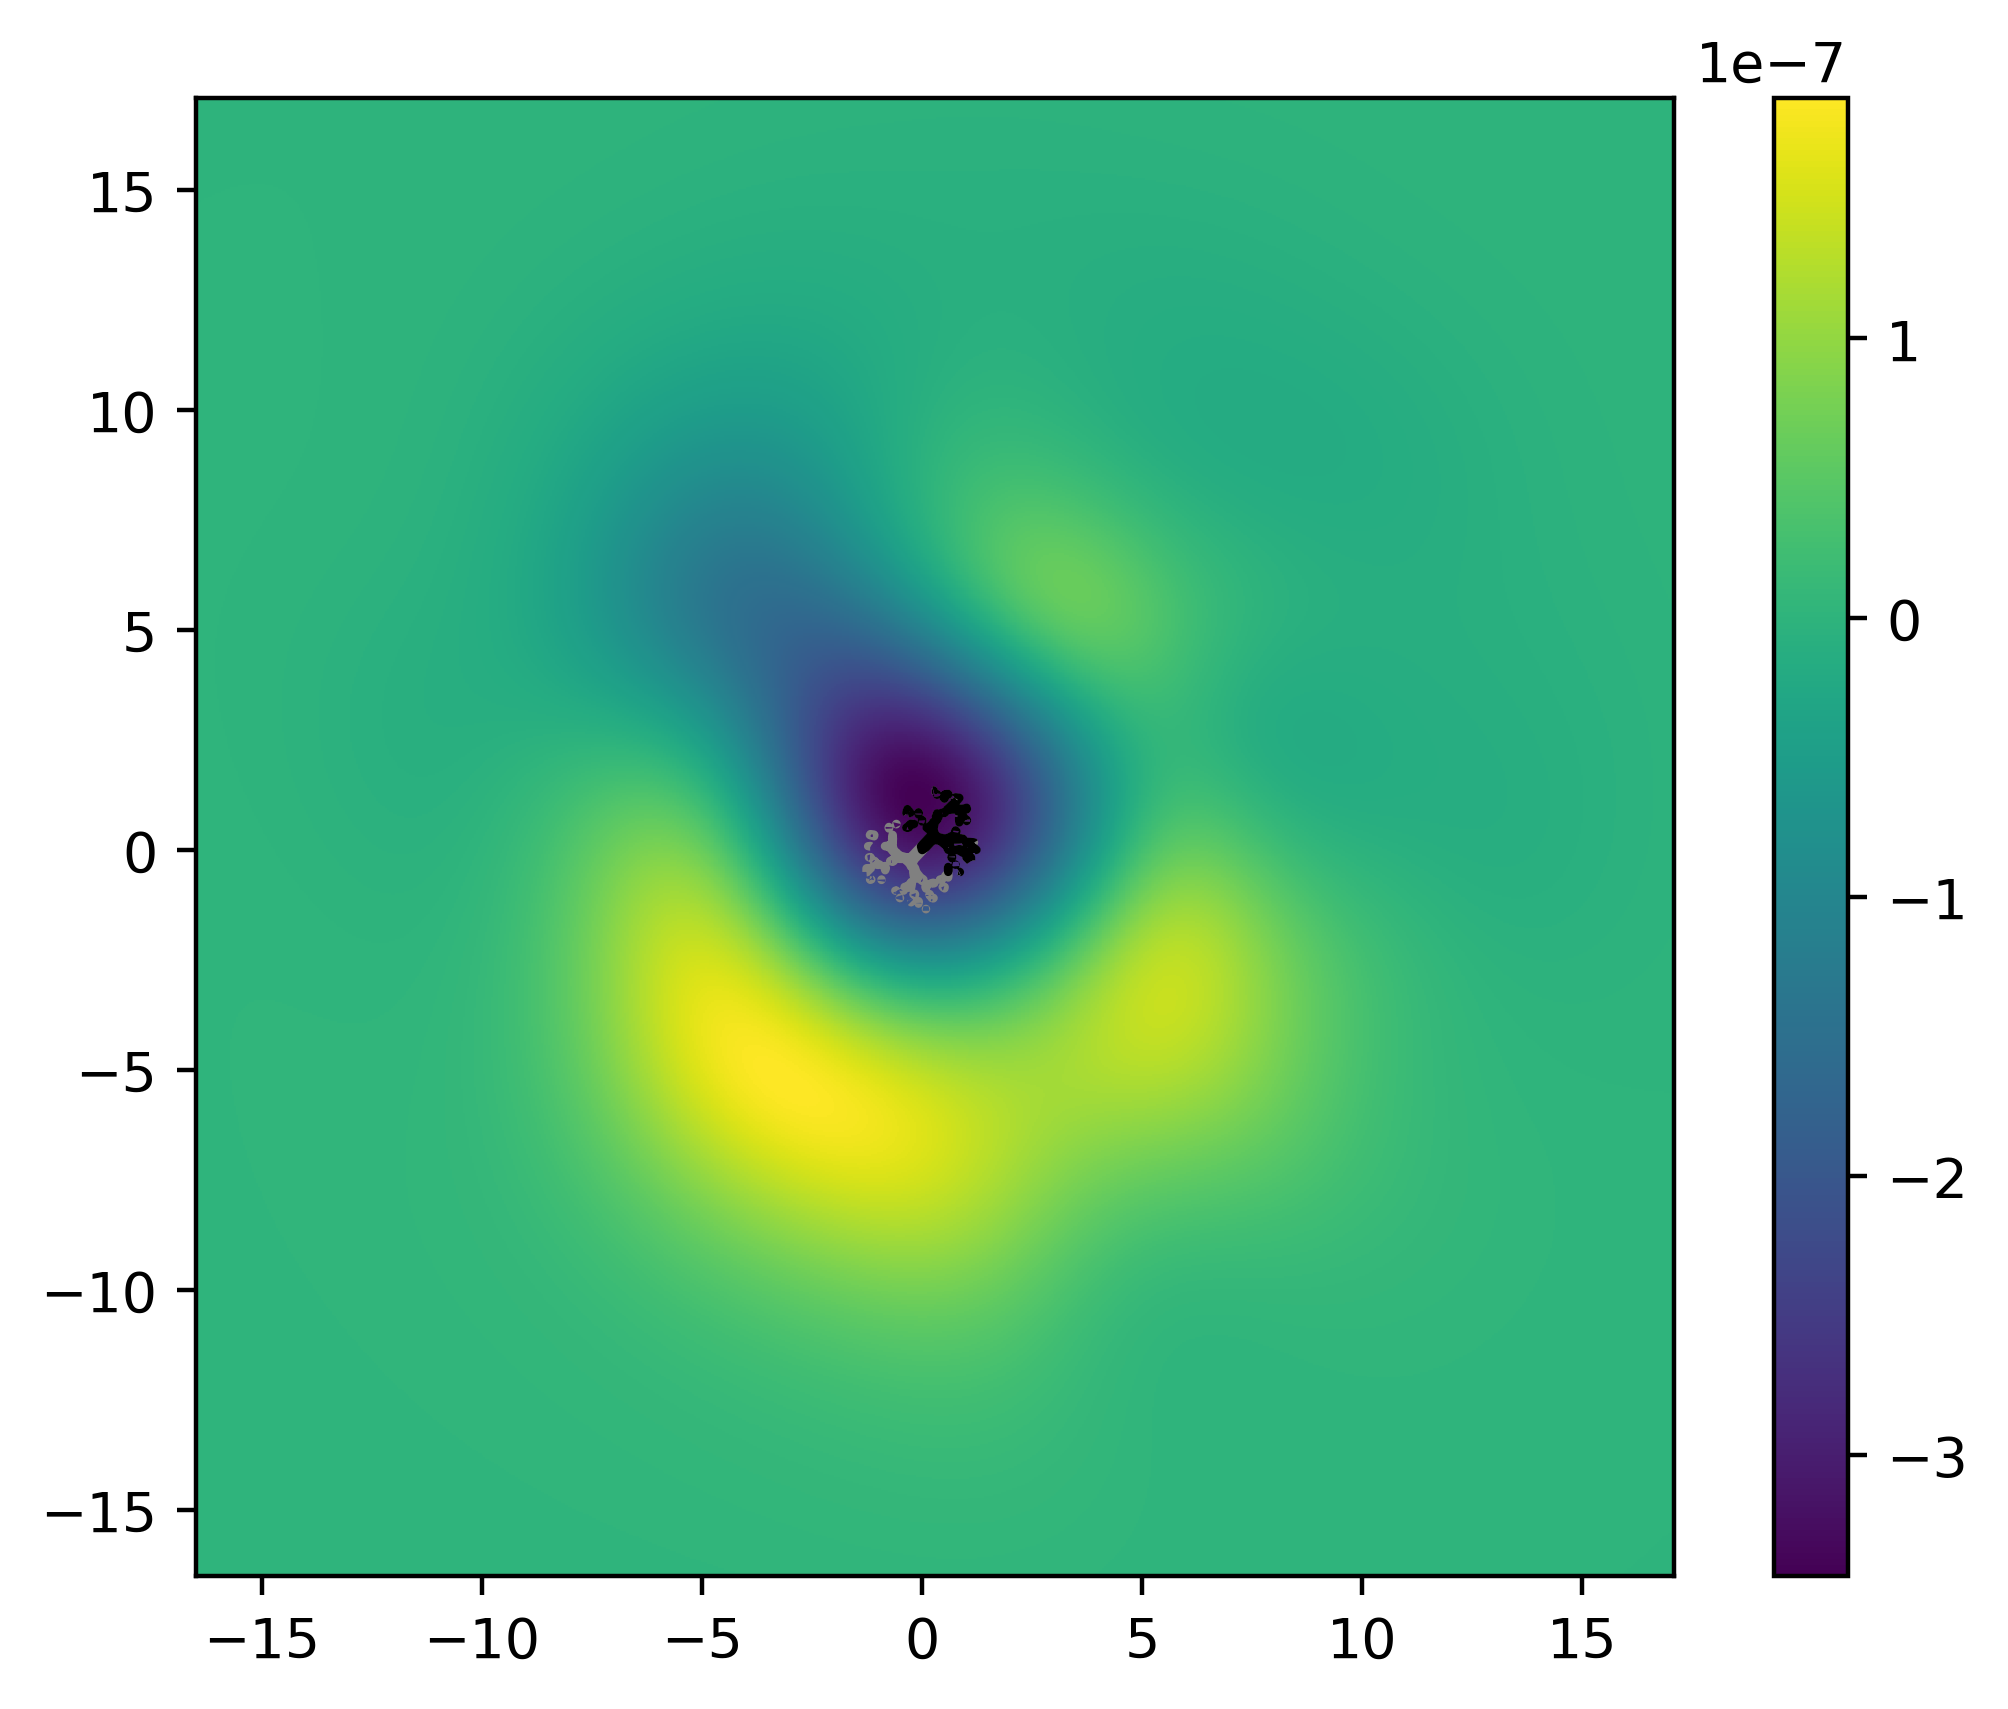

In [ ]:
grid_resolution = 801
zoom_out = 28
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*2*fig1_kwargs["view_size"]

kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
                                (x_centre, y_centre), (x_side, y_side), 
                                normalize=normalize)
print("KL div", kl_div)

plot_KL_divergence_integral_arg_surf(guide, gtd, grid_resolution, 
                                     (x_centre, y_centre), (x_side, y_side),
                                     normalize=normalize);

plot_KL_divergence_integral_arg_map(guide, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side),
                                    normalize=normalize);

### Check minimum field of view required to converge

#### Unnormalized

In [56]:
grid_resolution = 401
zoom_out = [1, 2, 4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 48]

guide_results, net_results = [], []
for zout in zoom_out:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zout*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
                                          (x_centre, y_centre), (x_side, y_side))
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, grid_resolution, 
                                        (x_centre, y_centre), (x_side, y_side))
    net_results.append(net_kl_div)

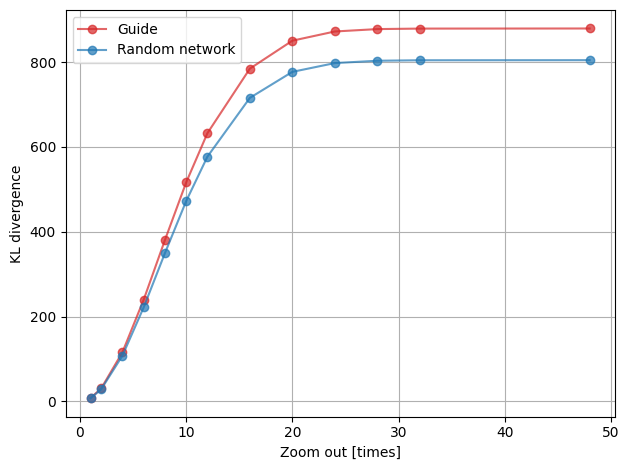

In [57]:
plt.figure()
plt.plot(zoom_out, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(zoom_out, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.legend()
plt.tight_layout()

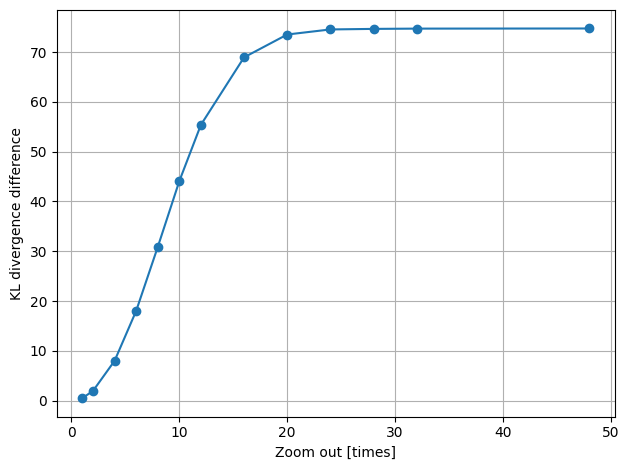

In [58]:
plt.figure()
plt.plot(zoom_out, np.array(guide_results)-np.array(net_results), "o-", color="C0")
plt.ylabel("KL divergence difference")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.tight_layout()

#### Normalized

In [24]:
grid_resolution = 801
zoom_out = [1, 2, 4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 48]
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True

guide_results, net_results = [], []
for zout in zoom_out:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zout*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
        (x_centre, y_centre), (x_side, y_side), normalize=normalize,
        pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max)
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, grid_resolution, 
        (x_centre, y_centre), (x_side, y_side), normalize=normalize,
        pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max)
    net_results.append(net_kl_div)

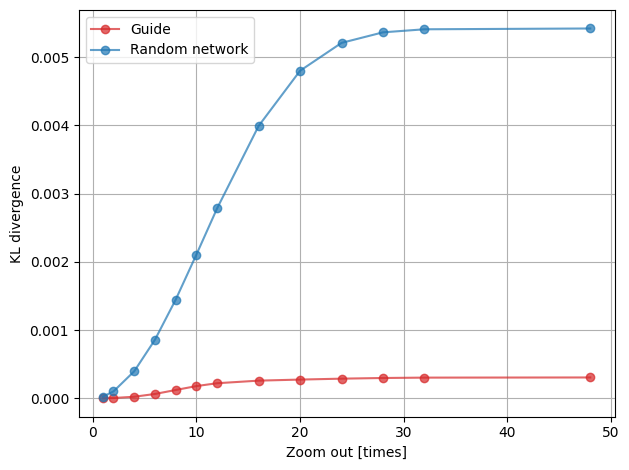

In [25]:
plt.figure()
plt.plot(zoom_out, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(zoom_out, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.legend()
plt.tight_layout()

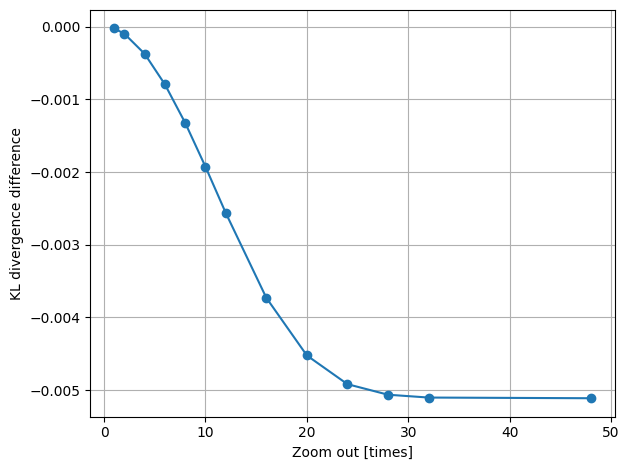

In [26]:
plt.figure()
plt.plot(zoom_out, np.array(guide_results)-np.array(net_results), "o-", color="C0")
plt.ylabel("KL divergence difference")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.tight_layout()

##### Sum normalized

In [50]:
grid_resolution = 801
zoom_out = [1, 2, 4, 6, 8, 10, 12, 16, 20, 24, 28, 32, 48]
normalize = True

guide_results, net_results = [], []
for zout in zoom_out:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zout*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, grid_resolution, 
                                          (x_centre, y_centre), (x_side, y_side),
                                          normalize=normalize)
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, grid_resolution, 
                                        (x_centre, y_centre), (x_side, y_side),
                                          normalize=normalize)
    net_results.append(net_kl_div)

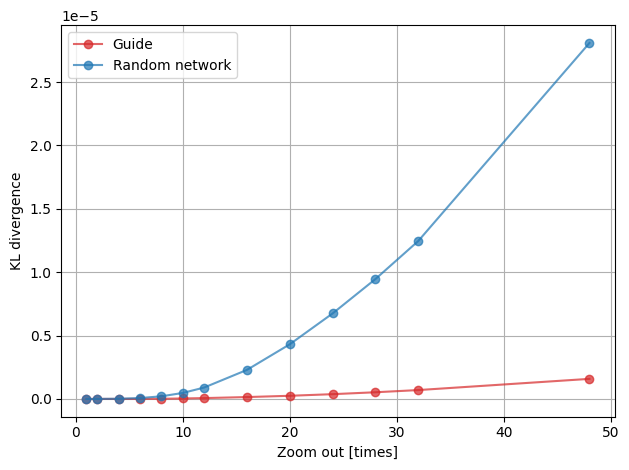

In [51]:
plt.figure()
plt.plot(zoom_out, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(zoom_out, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.legend()
plt.tight_layout()

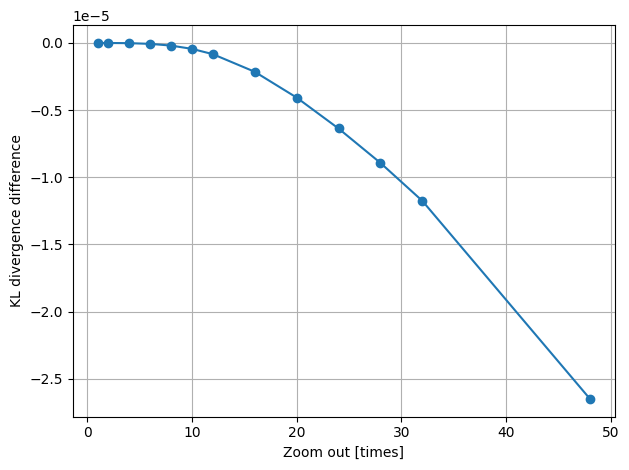

In [52]:
plt.figure()
plt.plot(zoom_out, np.array(guide_results)-np.array(net_results), "o-", color="C0")
plt.ylabel("KL divergence difference")
plt.xlabel("Zoom out [times]")
plt.grid()
plt.tight_layout()

### Check minimum resolution needed

#### Unnormalized

In [59]:
grid_resolution = [101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801]
zoom_out = 8

guide_results, net_results = [], []
for gres in grid_resolution:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zoom_out*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, gres, 
                                          (x_centre, y_centre), (x_side, y_side))
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, gres, 
                                        (x_centre, y_centre), (x_side, y_side))
    net_results.append(net_kl_div)

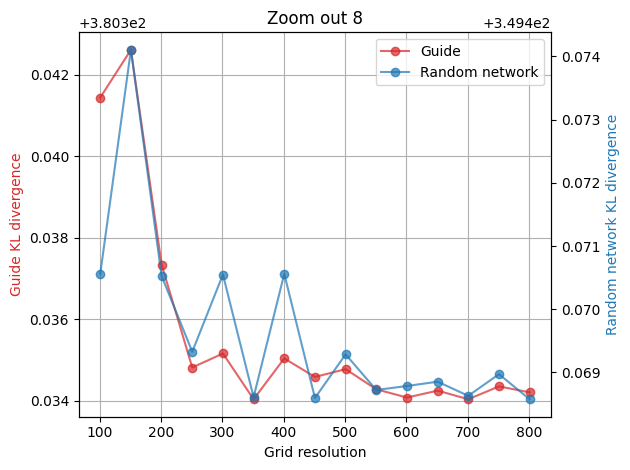

In [61]:
fig, ax = plt.subplots()
plt.title(f"Zoom out {zoom_out:.0f}")
ax2 = plt.twinx(ax)
l1, = ax.plot(grid_resolution, guide_results, "o-", color="C3", alpha=.7, label="Guide")
l2, = ax2.plot(grid_resolution, net_results, "o-", color="C0", alpha=.7, label="Random network")
ax.yaxis.label.set_color('C3') 
ax2.yaxis.label.set_color('C0') 
ax.set_ylabel("Guide KL divergence")
ax2.set_ylabel("Random network KL divergence")
ax.set_xlabel("Grid resolution")
ax.grid()
plt.legend([l1, l2], ["Guide", "Random network"])
plt.tight_layout()

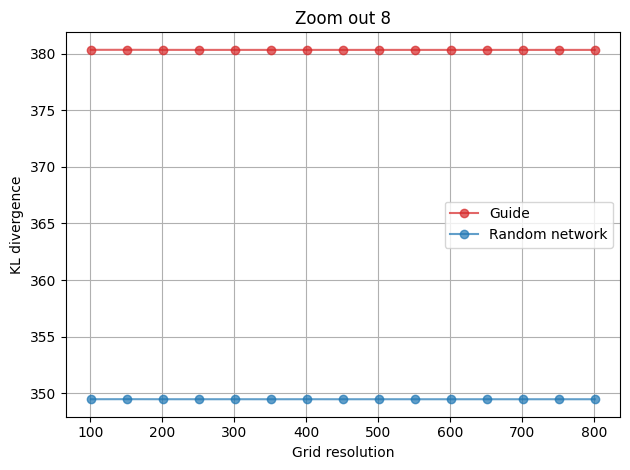

In [63]:
plt.figure()
plt.title(f"Zoom out {zoom_out:.0f}")
plt.plot(grid_resolution, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(grid_resolution, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Grid resolution")
plt.grid()
plt.legend()
plt.tight_layout()

#### Normalized

In [22]:
grid_resolution = [101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 1001]
zoom_out = 28
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True

guide_results, net_results = [], []
for gres in grid_resolution:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zoom_out*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, gres, 
        (x_centre, y_centre), (x_side, y_side), normalize=normalize,
        pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max)
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, gres, 
        (x_centre, y_centre), (x_side, y_side), normalize=normalize,
        pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max)
    net_results.append(net_kl_div)

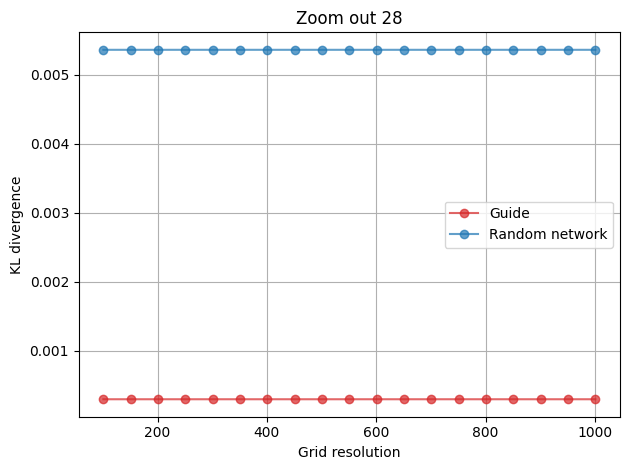

In [23]:
plt.figure()
plt.title(f"Zoom out {zoom_out:.0f}")
plt.plot(grid_resolution, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(grid_resolution, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Grid resolution")
plt.grid()
plt.legend()
plt.tight_layout()

##### Sum normalized

In [46]:
grid_resolution = [101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601, 651, 701, 751, 801, 851, 901, 951, 1001]
zoom_out = 28
normalize = True

guide_results, net_results = [], []
for gres in grid_resolution:

    x_centre = fig1_kwargs["view_x"]
    y_centre = fig1_kwargs["view_y"]
    y_side = x_side = zoom_out*fig1_kwargs["view_size"]

    guide_kl_div = estimate_KL_divergence(guide, gtd, gres, 
                                          (x_centre, y_centre), (x_side, y_side),
                                          normalize=normalize)
    guide_results.append(guide_kl_div)

    net_kl_div = estimate_KL_divergence(net, gtd, gres, 
                                        (x_centre, y_centre), (x_side, y_side),
                                        normalize=normalize)
    net_results.append(net_kl_div)

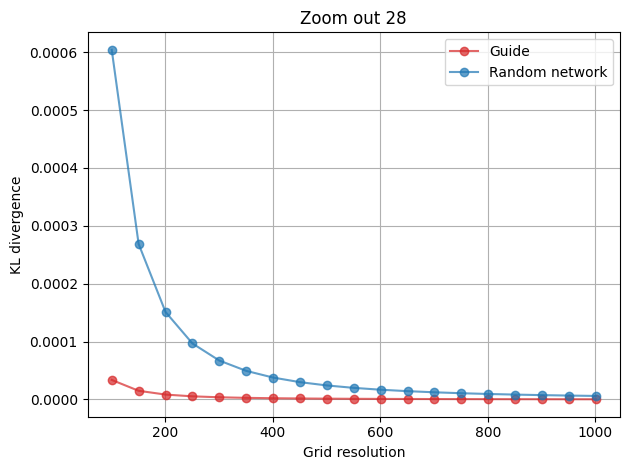

In [47]:
plt.figure()
plt.title(f"Zoom out {zoom_out:.0f}")
plt.plot(grid_resolution, guide_results, "o-", color="C3", alpha=.7, label="Guide")
plt.plot(grid_resolution, net_results, "o-", color="C0", alpha=.7, label="Random network")
plt.ylabel("KL divergence")
plt.xlabel("Grid resolution")
plt.grid()
plt.legend()
plt.tight_layout()

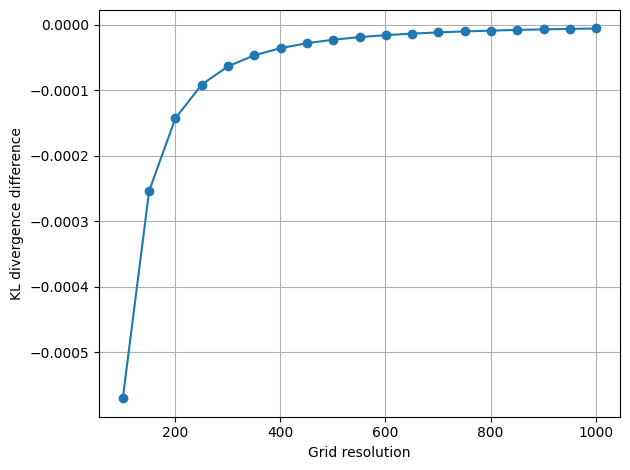

In [49]:
plt.figure()
plt.plot(grid_resolution, np.array(guide_results)-np.array(net_results), "o-", color="C0")
plt.ylabel("KL divergence difference")
plt.xlabel("Grid resolution")
plt.grid()
plt.tight_layout()

### Check for all different checkpoints in a training run

In [ ]:
series = ["InvertedGuideACID", "NoACIDGuide"]

checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints.sort()
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

#### Unnormalized

In [71]:
grid_resolution = 401
zoom_out = 24

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zout*fig1_kwargs["view_size"]

results = []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    
    # Estimate
    kl_div = estimate_KL_divergence(model, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side))
    results.append( kl_div )

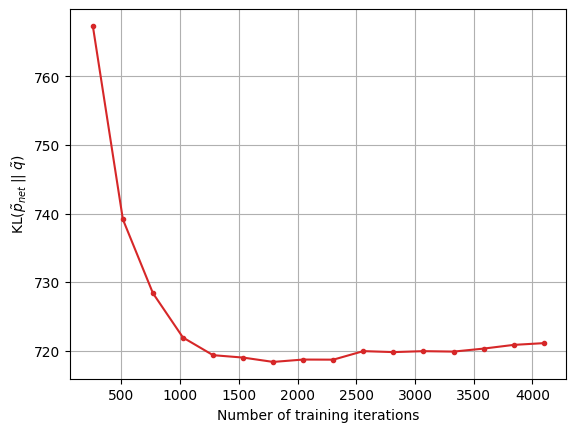

In [72]:
plt.figure()
plt.plot(n_iterations, results, ".-", color="C3")
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

#### Normalized

In [35]:
series = ["InvertedGuideACID", "NoACIDGuided"]
get_checkpoints_path = lambda s : os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", s)
grid_resolution = 801
zoom_out = 28
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True
plotting = False

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*fig1_kwargs["view_size"]

results = {}

for s in series:
    checkpoints_path = get_checkpoints_path(s)

    checkpoints = os.listdir(checkpoints_path)
    checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
    checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
    checkpoints.sort()
    checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
    n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

    these_results = []
    for iter, filepath in zip(n_iterations, checkpoints_filepaths):
        
        # Load checkpoint
        with builtins.open(filepath, "rb") as f:
            model = pickle.load(f).to(device)
        
        # Estimate
        kl_div = estimate_KL_divergence(model, gtd, grid_resolution, 
            (x_centre, y_centre), (x_side, y_side), normalize=normalize,
            pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max,
            surf_plotting=plotting)
        these_results.append( kl_div )

        # Save surface plot
        if plotting:
            fig = plt.gcf()
            fig.axes[0].set_zlim([-0.0002, 0.0002])
            fig.savefig(os.path.join(dirs.RESULTS_HOME, f"KL_arg_iter_{iter:04d}.png"))
            plt.close(fig)
    
    results[s] = these_results

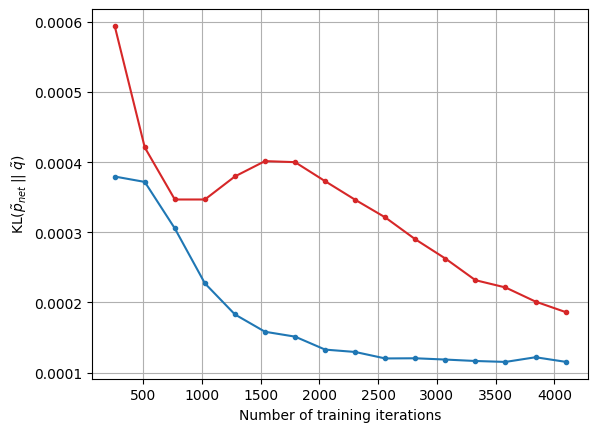

In [36]:
plt.figure()
plt.plot(n_iterations, results["InvertedGuideACID"], ".-", color="C3")
plt.plot(n_iterations, results["NoACIDGuided"], ".-", color="C0")
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

##### Sum normalized

In [65]:
grid_resolution = 801
zoom_out = 28
normalize = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zout*fig1_kwargs["view_size"]

results = []
for iter, filepath in zip(n_iterations, checkpoints_filepaths):
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    
    # Estimate
    kl_div = estimate_KL_divergence(model, gtd, grid_resolution, 
                                    (x_centre, y_centre), (x_side, y_side),
                                    normalize=normalize)
    results.append( kl_div )
    
    # Plot
    fig = plot_KL_divergence_integral_arg_surf(model, gtd, grid_resolution, 
                                               (x_centre, y_centre), (x_side, y_side), 
                                               normalize=normalize, alpha=.5);
    fig.savefig(os.path.join(dirs.RESULTS_HOME, f"KL_arg_iter_{iter:04d}.png"))
    plt.close(fig)

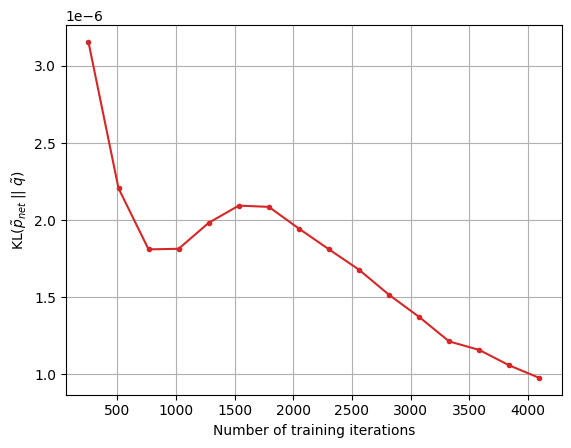

In [57]:
plt.figure()
plt.plot(n_iterations, results, ".-", color="C3")
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

### Final checkpoints comparison

In [40]:
series = ["InvertedGuideACID", "NoACIDGuided"]
get_checkpoints_path = lambda s : os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", s)
grid_resolution = 801
zoom_out = 28
normalize = True
sigma_min = 0.002
sigma_max = 5
pure_Gaussian = True
plotting = True

x_centre = fig1_kwargs["view_x"]
y_centre = fig1_kwargs["view_y"]
y_side = x_side = zoom_out*fig1_kwargs["view_size"]

results = {}
for s in series:
    checkpoints_path = get_checkpoints_path(s)

    checkpoints = os.listdir(checkpoints_path)
    checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
    checkpoints.sort()
    learner_filepath = os.path.join(checkpoints_path, checkpoints[-1])
    checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
    checkpoints.sort()
    ema_filepath = os.path.join(checkpoints_path, checkpoints[-1])

    these_results = {}
    for n, filepath in zip(["learner", "EMA"], [learner_filepath, ema_filepath]):
        
        # Load checkpoint
        with builtins.open(filepath, "rb") as f:
            model = pickle.load(f).to(device)
        
        # Estimate
        kl_div = estimate_KL_divergence(model, gtd, grid_resolution, 
            (x_centre, y_centre), (x_side, y_side), normalize=normalize,
            pure_Gaussian=pure_Gaussian, sigma_min=sigma_min, sigma_max=sigma_max,
            surf_plotting=plotting)
        these_results[n] = kl_div

        # Save surface plot
        if plotting:
            fig = plt.gcf()
            fig.axes[0].set_zlim([-0.0002, 0.0002])
            fig.savefig(os.path.join(checkpoints_path, f"KL_arg_{n}.png"))
            plt.close(fig)
    
    results[s] = these_results

In [41]:
results

{'InvertedGuideACID': {'learner': 0.0001822376289367676,
  'EMA': 0.00018633208012580873},
 'NoACIDGuided': {'learner': 0.00012103001308441163,
  'EMA': 0.00011542219781875612}}